# Projet STATISTIQUES - Étude de données météo - Notebook de Paul

Groupe : Choquet Laura, Oncle Valentin, Laisné Paul, Maubian Joséphine, Regaieg Mohamed

## Exploration et présentation des données

Les données utilisées dans ce projet sont des données météorologiques provenant de la source suivante : 
https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/donnees-synop-essentielles-omm/exports/csv?lang=fr&qv1=(date%3A%5B2015-08-03T22%3A00%3A00Z%20TO%202025-09-03T21%3A59%3A59Z%5D)&timezone=Europe%2FBerlin&use_labels=true&delimiter=%3B


In [ ]:
# Chargement des données d'observations

global_data <- read.csv("../data/observations.csv", sep = ",") # Remplacer par le chemin correct


In [ ]:
# Informations générales sur le jeu global des observations

cat(strrep("-", 50), "\n")
cat("Dimension du dataset\n")
cat(strrep("-", 50), "\n")
dim_data <- dim(global_data)
cat("Nb d'observations :", dim_data[1], "\n")
cat("Nb de variables :", dim_data[2], "\n")

-------------------------------------------------- 
Dimension du dataset
-------------------------------------------------- 
Nb d'observations : 1719567 
Nb de variables : 66 


-------------------------------------------------- 
Analyse des données manquantes (en pourcentage)
-------------------------------------------------- 
                                           ID.OMM.station 
                                                    0.000 
                                                     Date 
                                                    0.000 
                                   Pression.au.niveau.mer 
                                                    5.488 
                        Variation.de.pression.en.3.heures 
                                                    2.367 
                            Type.de.tendance.barométrique 
                                                    3.968 
                            Direction.du.vent.moyen.10.mn 
                                                    0.863 
                              Vitesse.du.vent.moyen.10.mn 
                                                    0.845 
                      

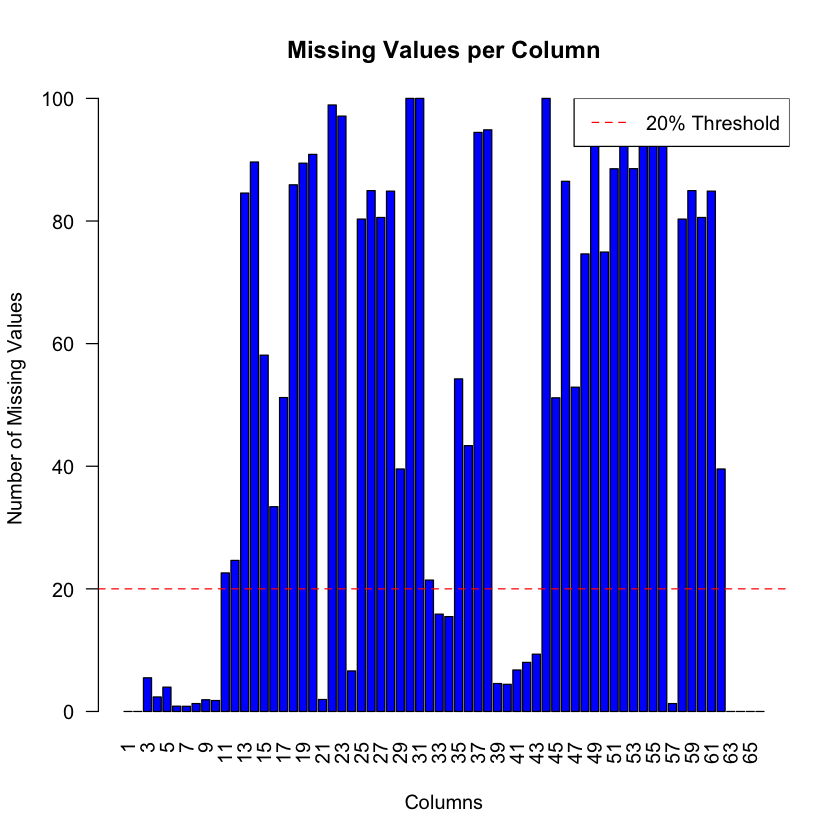

In [28]:
# Analyse des données manquantes (en pourcentage)
missing_values_percent <- colMeans(is.na(global_data)) * 100
cat(strrep("-", 50), "\n")
cat("Analyse des données manquantes (en pourcentage)\n")
cat(strrep("-", 50), "\n")
print(round(missing_values_percent, 3))

# Affichage dans un histogramme des valeurs manquantes par colonne
par(bg = "white")
barplot(missing_values_percent, main = "Missing Values per Column", 
        xlab = "Columns", ylab = "Number of Missing Values", col = "blue", las = 2,
        names.arg = seq_along(missing_values_percent))
# Rajouter une ligne horizontale pour indiquer un seuil de tolérance
abline(h = 20, col = "red", lty = 2)
legend("topright", legend = "20% Threshold", col = "red", lty = 2)

Remarque : Le jeu de données contient un nombre important de colonnes, mais beaucoup d'entre elles sont peu remplies. Certaines variables ont un taux de données manquantes très élevé (de 80 à 100 %). Et une grande majorité a un taux supérieur à 30 % ce qui limitent grandement leur utilisation dans des modèles statistiques.

# Présentation des données
Nous avons choisi de nous concentrer sur les stations de la france métropolitaine pour visualiser plus simplement les stations sur une carte et assurer une cohérence géographique entre les climats. Les stations d'outremer proposent également des mesures moins bien répartis dans le temps avec parfois de grands intervals de temps entre chaque mesure.

<p float="left">
  <img src="../fig/heatmap_points_Humidit_.png" width="450" />
  <img src="../fig/heatmap_points_Pr_cipitations_dans_les_24_derni_res_heures.png" width="450" />
  <img src="../fig/heatmap_points_Temp_rature.png" width="450" />
</p>

Comme attendu les lieux les moins humides, les plus chauds et ou il y a le moins d'humidité sont dans le sud de la France. On constate aussi que le nord de la France est en moyenne plus froide que le sud et la bretagne plus sujet aux précipitations que ce soit en volume ou en fréquence.

## Matrice de corrélation

Après avoir nettoyé les données nous avons effectué des calculs de corrélarions entre variables. 

In [11]:
source('corr.R')

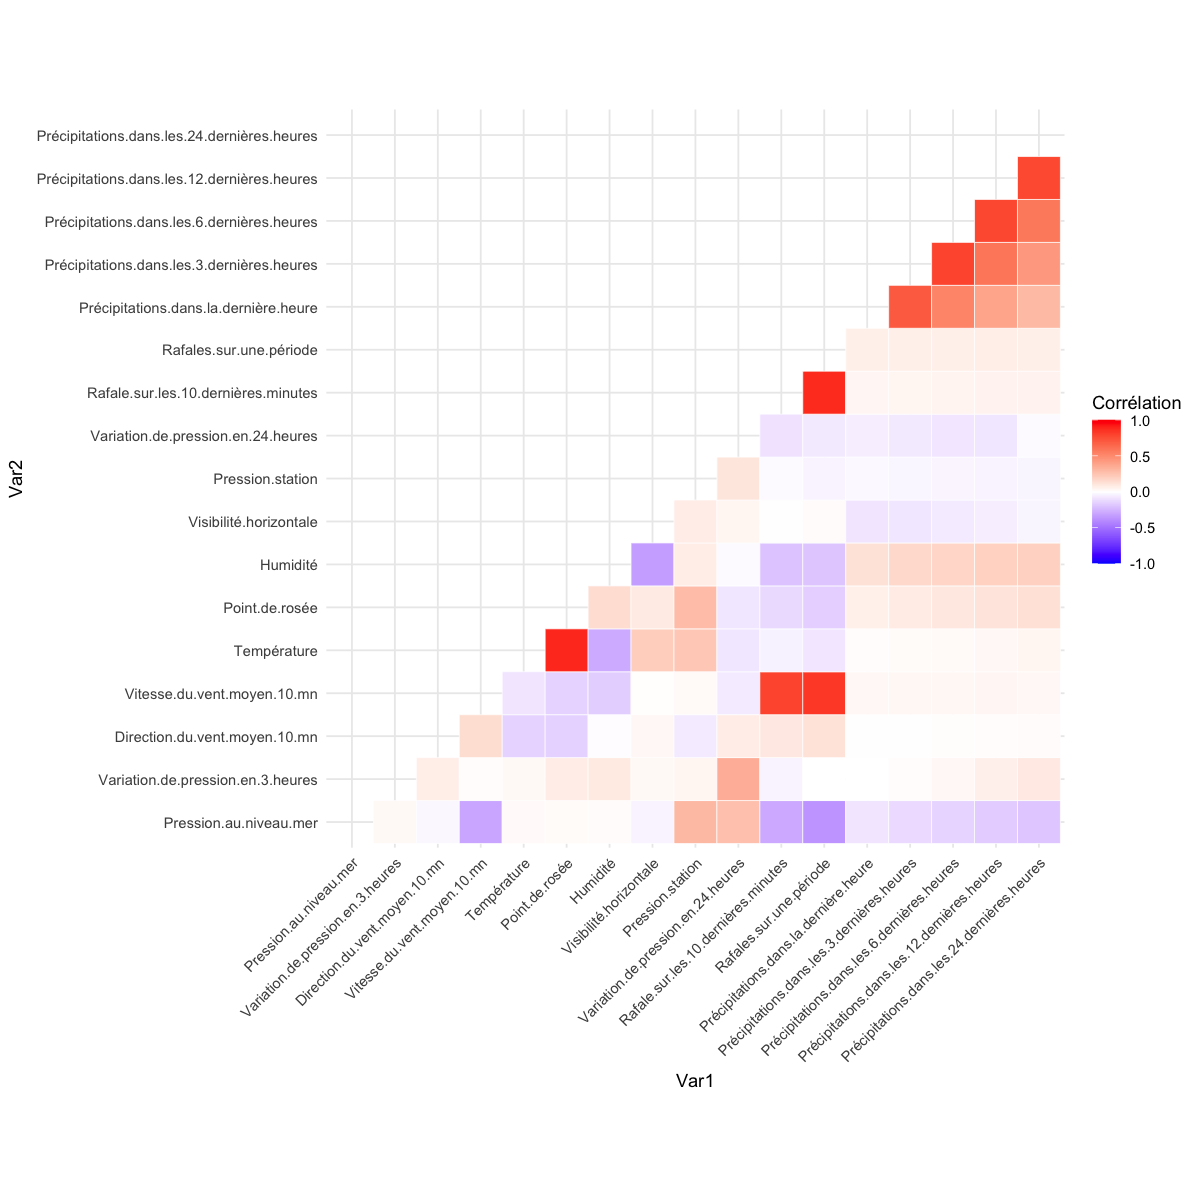

In [21]:
res <- analyze_correlations("../csv/observations_cleaned.csv")
options(repr.plot.width = 10, repr.plot.height = 10)
res$plot

Cette matrice de corrélation a été calculée sur l'ensemble des données d'observations de France métropolitaine.
On observe certaines corrélations évidentes comme celles entre les différentes précipitations pendant les dernières $n$ heures. 
Pour effectuer une régression ou un clusters on pourrait supprimer certaines variables redondantes.

In [22]:
head(res$correlations)  

Var1                                       
1 Point.de.rosée                             
2 Rafales.sur.une.période                    
3 Rafales.sur.une.période                    
4 Précipitations.dans.les.6.dernières.heures 
5 Rafale.sur.les.10.dernières.minutes        
6 Précipitations.dans.les.12.dernières.heures
  Var2                                       Corr     
1 Température                                0.8952098
2 Rafale.sur.les.10.dernières.minutes        0.8859623
3 Vitesse.du.vent.moyen.10.mn                0.8393475
4 Précipitations.dans.les.3.dernières.heures 0.7975094
5 Vitesse.du.vent.moyen.10.mn                0.7957731
6 Précipitations.dans.les.6.dernières.heures 0.7832608

Cette cellule affiche les 5 variables les plus corrélées.

# Présentation des données
## Import des fonctions

In [11]:
source("../src/plot_over_months_by_station.R")
source("../src/plot_station_avg_by_month.R")
source("../src/plot_boxplot_by_season.R")

## Import de la base donnée des observations

In [12]:
data <- read.csv("../csv/observations.csv", header = TRUE, sep = ",")
print(dim(data))  # Print the dimensions of the data frame

[1] 1719567      62


## Import de la base de données de stations

In [13]:
stations <-read.csv("../csv/stations.csv", header = TRUE, sep = ",")
print(dim(stations))  # Print the dimensions of the data frame

[1] 62 12


##### On va regarder dans cette partie que les stations dans France métropôle

In [14]:
library(dplyr)

# Codes Insee des régions métropolitaines (hors DROM-COM)
codes_metropole <- c(11, 24, 27, 28, 32, 44, 52, 53, 75, 76, 84, 94) 

# ---- 1. Filtrer les stations métropolitaines ----
stations_metropole <- stations %>% 
  dplyr::filter(region..code. %in% codes_metropole)

# Récupérer la liste des ID de stations métropolitaines
id_metropole <- stations_metropole$ID.OMM.station

# ---- 2. Charger la base observations météo ----
# Exemple : data <- read.csv("observations.csv")

# Filtrer uniquement les observations de France métropolitaine
data_metropole <- data %>% 
  dplyr::filter(ID.OMM.station %in% id_metropole)

### Suivi d'évolution **mensuelle** de quelques variables 
 

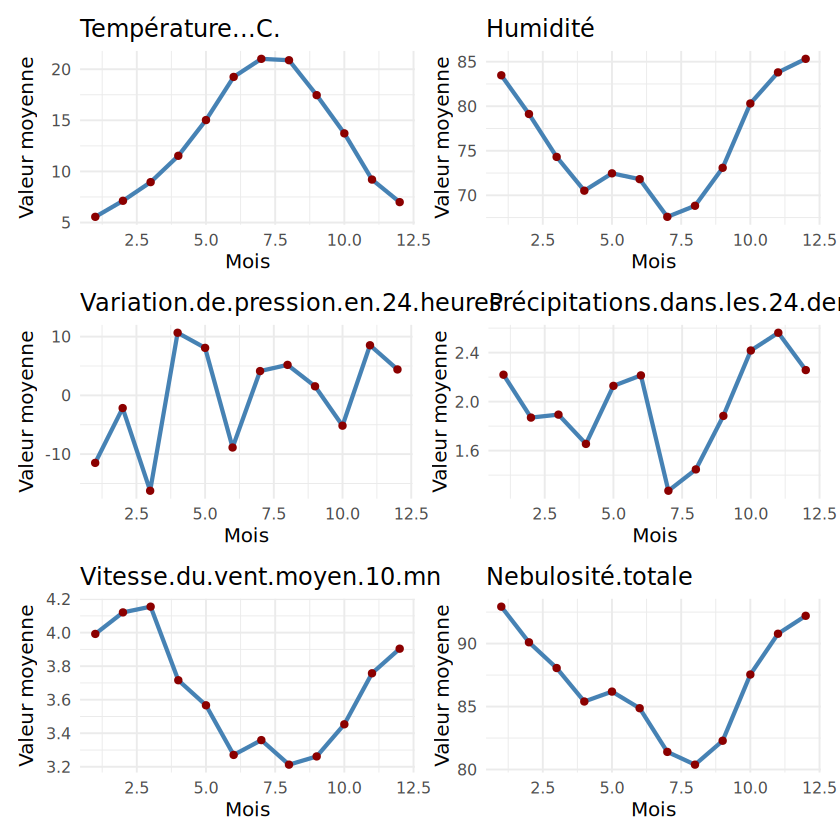

In [ ]:
library(dplyr)
library(ggplot2)
library(patchwork)



# ---- 1. Charger la base des métadonnées stations (communes/régions) ----
# exemple : stations <- read.csv("stations.csv")



# Variables sélectionnées
vars <- c("Température...C.", 
          "Humidité", 
          "Variation.de.pression.en.24.heures", 
          "Précipitations.dans.les.24.dernières.heures", 
          "Vitesse.du.vent.moyen.10.mn", 
          "Nebulosité.totale")

# Générer les graphiques
plots <- lapply(vars, function(v) {
  data_metropole %>%
    group_by(mois_de_l_annee) %>%
    summarise(val_moy = mean(.data[[v]], na.rm = TRUE)) %>%
    ggplot(aes(x = mois_de_l_annee, y = val_moy)) +
    geom_line(color = "steelblue", size = 1.2) +
    geom_point(color = "darkred") +
    theme_minimal(base_size = 12) +
    labs(title = paste(v),
         x = "Mois",
         y = "Valeur moyenne")
})

# ⚡ Organiser en grille 3 x 2
(plots[[1]] | plots[[2]]) / 
(plots[[3]] | plots[[4]]) / 
(plots[[5]] | plots[[6]])


En moyennant les valeurs sur l’ensemble des mois, on observe que certaines variables présentent une évolution clairement saisonnière :

* **La température**, **l’humidité relative**, **la vitesse moyenne du vent** et **la nébulosité totale** suivent une tendance de type sinusoïdal. Cette variation cyclique est cohérente avec la nature saisonnière de ces paramètres météorologiques.
* À l’inverse, **la variation de pression en 24 heures** et **les précipitations quotidiennes** ne montrent pas une évolution régulière ni cyclique. Leur comportement est plus aléatoire et dépend davantage d’événements ponctuels ou de phénomènes météorologiques spécifiques que d’un cycle saisonnier marqué.

### Suivi d'évolution **annuelle** des mêmes variables

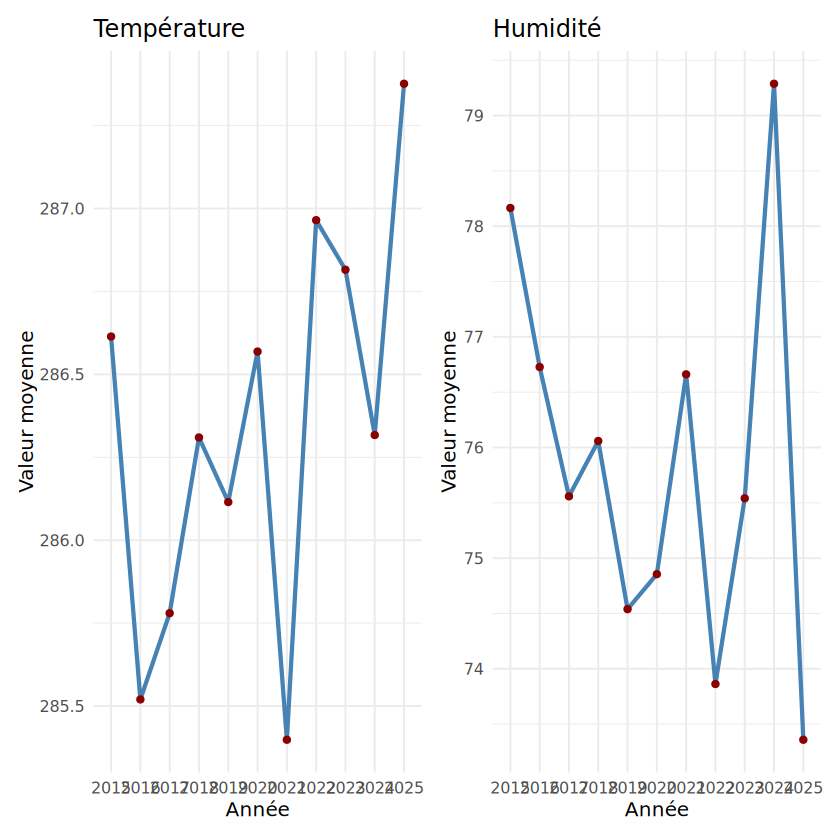

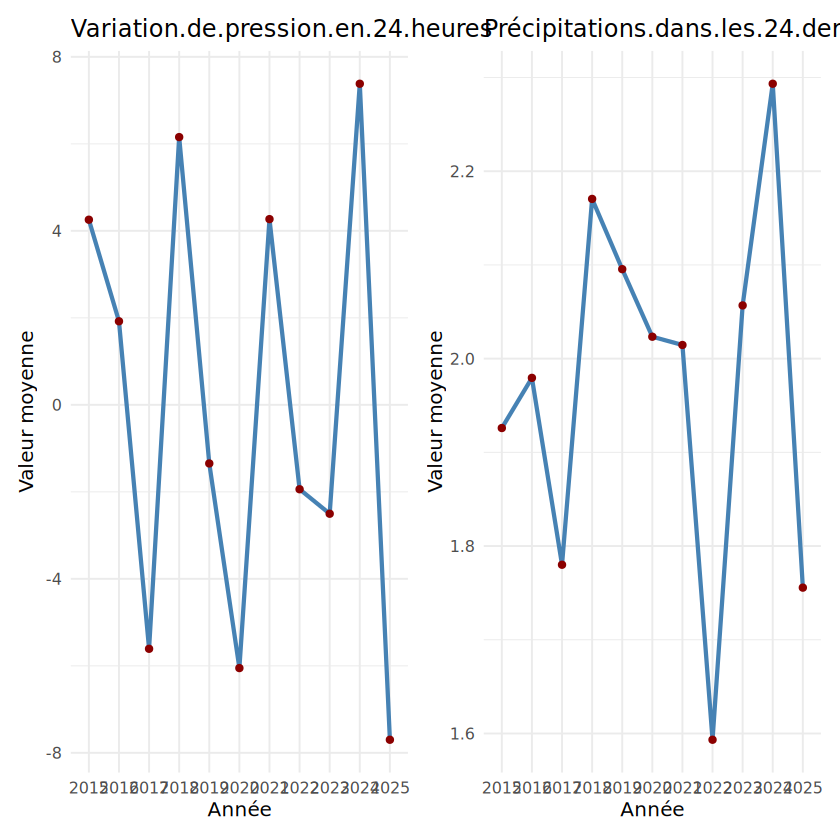

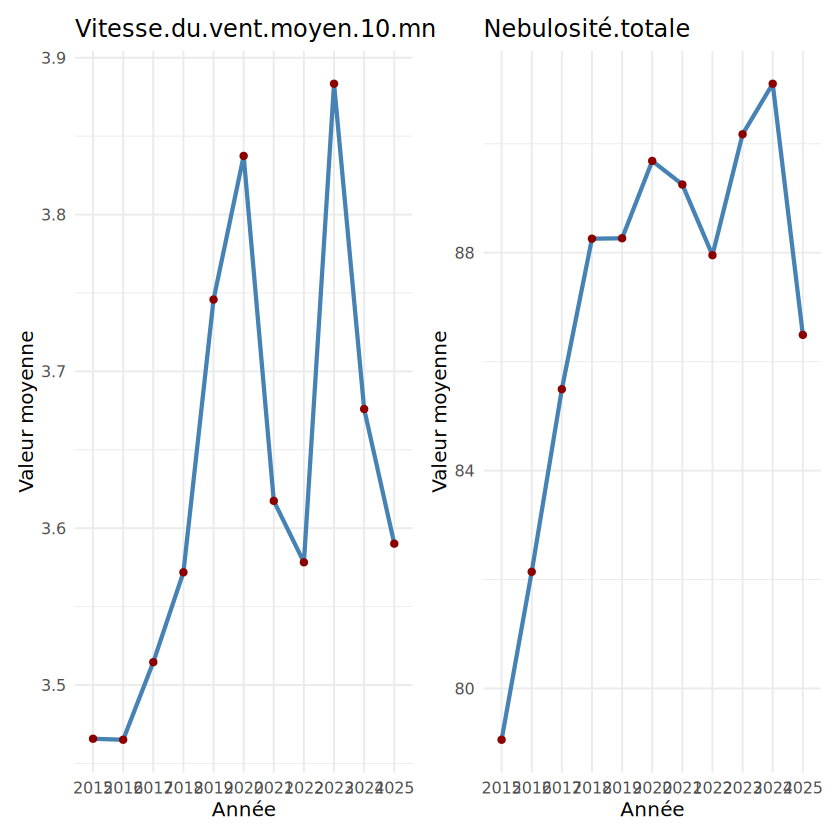

In [28]:
library(dplyr)
library(ggplot2)
library(patchwork)
# La colonne Date est de type caractère (ex: "2018-04-04T05:00:00+02:00")
data_metropole <- data_metropole %>%
  mutate(annee = format(as.Date(substr(Date, 1, 10)), "%Y"))
vars <- c("Température", 
          "Humidité", 
          "Variation.de.pression.en.24.heures", 
          "Précipitations.dans.les.24.dernières.heures", 
          "Vitesse.du.vent.moyen.10.mn", 
          "Nebulosité.totale")
# ---- Générer graphiques : moyennes par année ----
plots <- lapply(vars, function(v) {
  data_metropole %>%
    group_by(annee) %>%
    summarise(val_moy = mean(.data[[v]], na.rm = TRUE)) %>%
    ggplot(aes(x = annee, y = val_moy, group = 1)) +
    geom_line(color = "steelblue", size = 1.2) +
    geom_point(color = "darkred") +
    theme_minimal(base_size = 12) +
    labs(title = paste(v),
         x = "Année",
         y = "Valeur moyenne")
})

# ---- Organiser en grille 3 x 2 ----
(plots[[1]] |plots[[2]])  
(plots[[3]] |plots[[4]]) #/ 
(plots[[5]] |plots[[6]]) 


Les variables température, vent et nébulosité semblent montrer des tendances pluriannuelles (hausse ou fluctuations dirigées).

En revanche, pression et précipitations présentent un caractère plus aléatoire, fortement influencé par les événements météorologiques ponctuels.

L’année 2025 ressort comme atypique, avec des valeurs extrêmes (température et humidité élevées, précipitations plus faibles, nébulosité en léger recul).

# Estimateurs, tests

In [ ]:
library(dplyr)
library(lubridate)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



---------------------
Welcome to dendextend version 1.19.1
Type citation('dendextend') for how to cite the package.

Type browseVignettes(package = 'dendextend') for the package vignette.
The github page is: https://github.com/talgalili/dendextend/

Suggestions and bug-reports can be submitted at: https://github.com/talgalili/dendextend/issues
You may ask questions at stackoverflow, use the r and dendextend tags: 
	 https://stackoverflow.com/questions/tagged/dendextend

	To suppress this message use:  suppressPackageStartupMessages(library(dendextend))
---------------------



Attaching package: ‘dendextend’


The following object is masked from ‘package:stats’:


In [ ]:
observations <- read.csv("../observations.csv")
observations <- observations %>%
  filter(Latitude >= 41 & Latitude <= 51,
         Longitude >= -5 & Longitude <= 10

In [12]:
stations = read.csv("../stations.csv")

Distribution de la température (seulement pour la France métropolitaine) ; nous pouvons observer une distribution qui ressemble à celle d'une loi normale

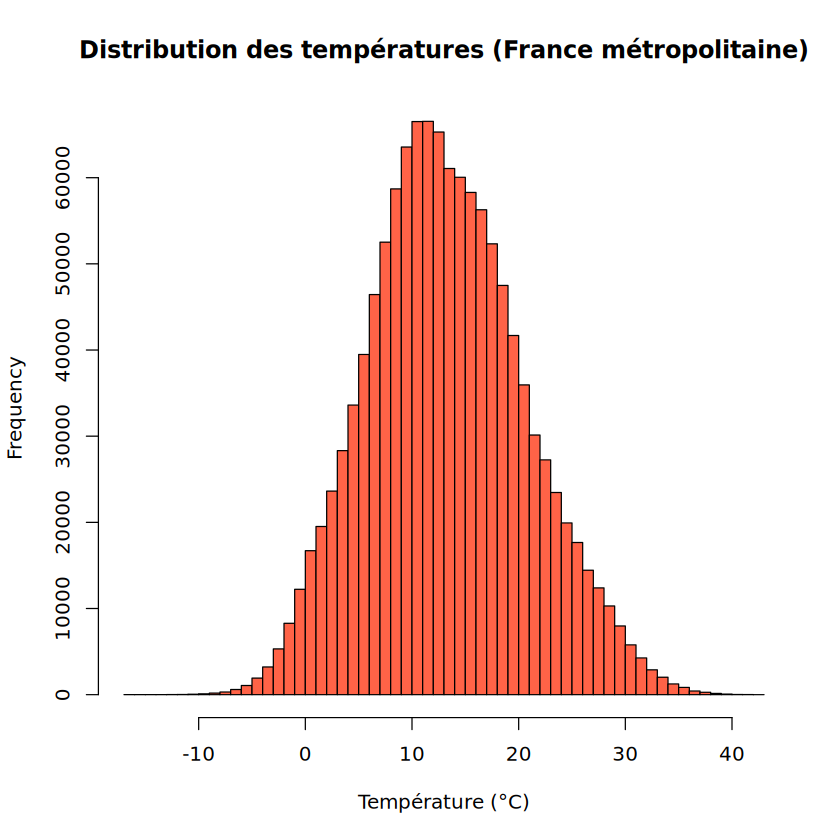

In [3]:
par(bg = 'white')
temp_C <- observations$Température - 273.15
hist(temp_C, breaks = 50, col = "tomato", main = "Distribution des températures (France métropolitaine)", xlab = "Température (°C)")

Distribution de la presion (seulement pour la France métropolitaine) ; cette fois-ci, pas de loi normale apparente

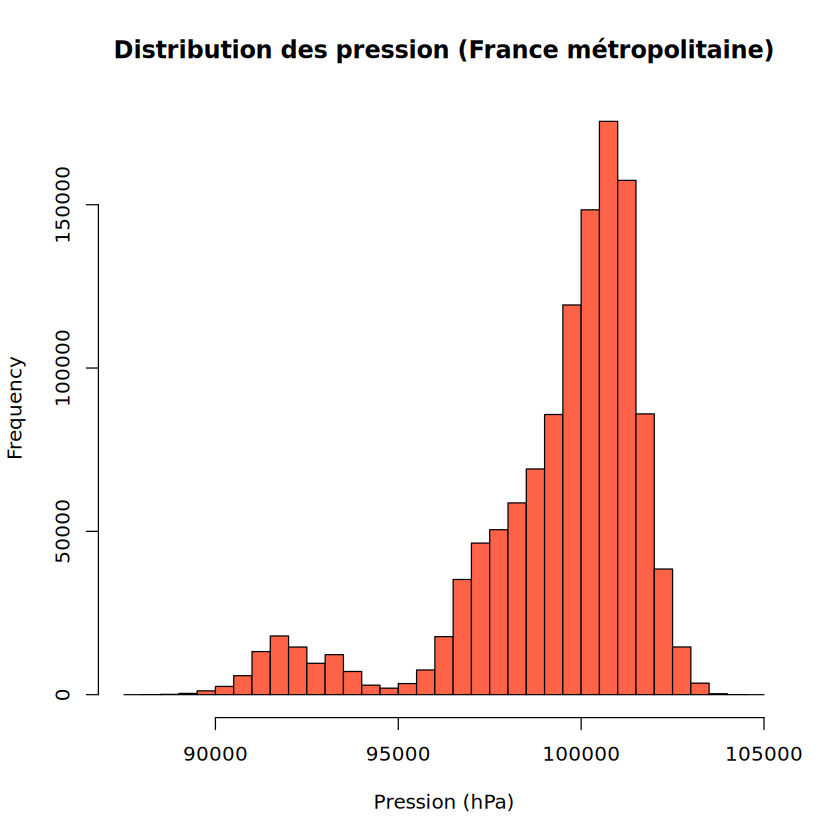

In [4]:
par(bg = 'white')
temp_C <- observations$Pression.station - 273.15
hist(temp_C, breaks = 50, col = "tomato", main = "Distribution des pression (France métropolitaine)", xlab = "Pression (hPa)")

Nous nous posons alors une première question : les températures au printemps et en automne ont-elles la même moyenne (sur toute la saison)?

Pour le vérifier, on fait un test avec t.test().

Nous observons une p-value très faible ($< 2.2 \times 10^{-16}$), ce qui indique que si elles avaient la même moyenne, on aurait une faible probabilité d'avoir ces observations.

In [5]:
spring <- subset(observations, mois_de_l_annee %in% c(4,5,6))$Température
fall <- subset(observations, mois_de_l_annee %in% c(9,10,11))$Température
print(cat("moyenne des température au printemps =", mean(spring, na.rm=TRUE)))
print(cat("moyenne des température en automne =", mean(fall, na.rm=TRUE)))
t.test(spring, mu = mean(fall, na.rm=TRUE))

moyenne des température au printemps = 288.5821NULL
moyenne des température en automne = 286.8119NULL



	One Sample t-test

data:  spring
t = 162.04, df = 298470, p-value < 2.2e-16
alternative hypothesis: true mean is not equal to 286.8119
95 percent confidence interval:
 288.5607 288.6035
sample estimates:
mean of x 
 288.5821 


Maintenant, on plot de l'évolution temporelle de la moyenne journalière de la moyenne des températures en France métropolitaine $T_{moy}(t)$ ; nous observons une sinusoïde, d'une période qui semble être d'un an.

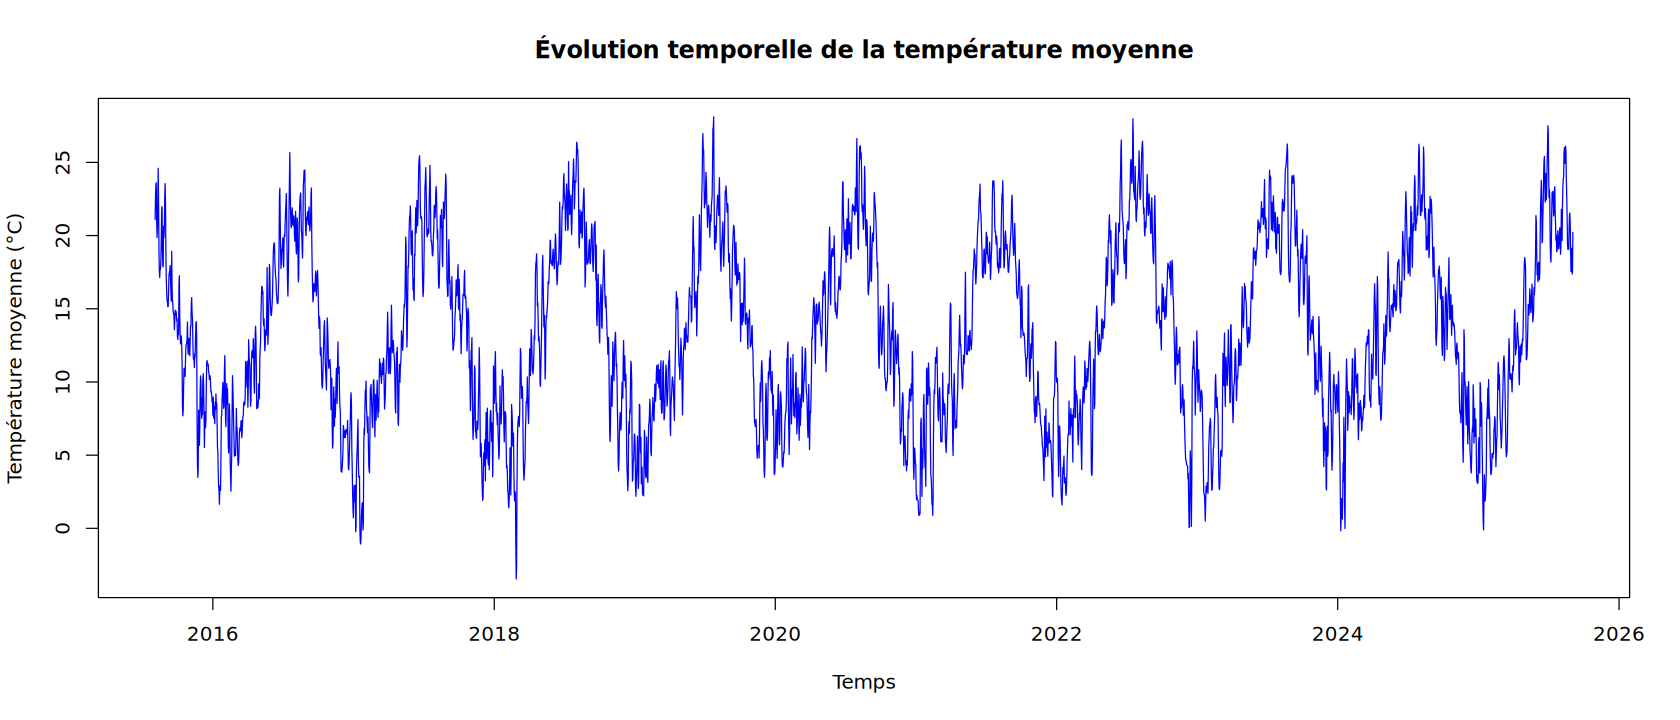

In [6]:
observations$Date <- as.POSIXct(observations$Date, format="%Y-%m-%dT%H:%M:%S", tz="UTC")
temp_jour <- observations %>%
  mutate(jour = as.Date(Date)) %>%
  group_by(jour) %>%
  summarise(temp_moy = mean(Température, na.rm = TRUE))

options(repr.plot.width=14, repr.plot.height=6)
par(bg = 'white')
plot(temp_jour$jour, temp_jour$temp_moy - 273.15, type="l",
     col="blue", xlab="Temps", ylab="Température moyenne (°C)",
     main="Évolution temporelle de la température moyenne")

Nous essayons d'estimer la période de $T_{moy}(t)$, avec la fonction nls() (nonlinear least squares) ; on retrouve bien environ 365 jours.

In [ ]:
temp_jour$t <- as.numeric(temp_jour$jour - min(temp_jour$jour))
fit_free <- nls(temp_moy ~ a + b * sin(2*pi*f*t + phi),
                data = temp_jour,
                start = list(a = mean(temp_jour$temp_moy, na.rm=TRUE),
                             b = 10,   # amplitude approx
                             f = 1/365, # fréquence initiale
                             phi = 0))
# summary(fit_free)
print(cat("période des varitions de température =", 1/coef(fit_free)["f"]))

Maintenant, nous séparons les températures (en France) en 4 groupes : les températures sur les périodes 2025-2027, 2018-2020, 2021-2023, et 2024. Nous cherchons à savoir si la température moyenne en France sur ces périodes a évoluée. Pour cela, nous effectuons une ANOVA.

Nous observons une p-value inférieure à $2 \times 10^{-16}$, ce qui indique que si les différents groupes avaient la même moyenne, on a une très faible probabilité d'avoir ces observations. En effet, on voit une légère augmentation de ces moyennes ; serait-ce dû au changement climatique ?

In [7]:
observations$annee <- year(as.Date(observations$Date))

observations$periode <- cut(observations$annee,
                            breaks = c(2014, 2017, 2020, 2023, 2026),
                            labels = c("2015-2017", "2018-2020", "2021-2023", "2024"))

moyennes_periode <- observations %>%
  group_by(periode) %>%
  summarise(temp_moy = mean(Température, na.rm = TRUE))

print(moyennes_periode)
anova_res <- aov(Température ~ periode, data = observations)
summary(anova_res)

# A tibble: 4 × 2
  periode   temp_moy
  <fct>        <dbl>
1 2015-2017     286.
2 2018-2020     287.
3 2021-2023     287.
4 2024          287.


                 Df   Sum Sq Mean Sq F value Pr(>F)    
periode           3    92372   30791   571.4 <2e-16 ***
Residuals   1208814 65137380      54                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
17973 observations deleted due to missingness

Maintenant, nous allons essayer de vérifier notre intuition que la distribution des températures suit une loi normale. Pour cela, nous mettons en place un test de Shapiro, à partir de 5000 températures tirées au hasard dans notre jeu de données (shapiro.test() n'autorise pas d'utiliser plus d'éléments).

La p-value de ce test est d'environ $4.5 \times 10^{-9}$, ce qui indique que si la distribution des tepératures suivait une loi normale, on aurait une faible probabilité d'avoir ces observations. Nous avons été quelque peu surpris, et nous avons quand même voulu tracer la distribution des 5000 températures prélevées.

Cela est sûrement dû au fait que l'observation d'une température à un moment donnée ne suit pas une loi normale de moyenne la moyenne totale des températures, mais dépend plutôt du jour de l'année et de l'heure d'observation.

Nous essayons alors autre chose : nous allons sélectionner les température pour un même jour sur plusieurs années (ici, ce sera le 21 décembre); pour chaque 21 décembre, nous faisons ensuite une moyenne de la température sur toute la journée. Finalement, on obtient 10 valeurs, à partir desquelles on va relancer un test de Shapiro. Nous obtenons alors une p-value de 0.06; toujours faible, donc.

In [8]:
set.seed(123)
temp_sample <- sample(observations$Température, 5000)
shapiro.test(temp_sample)


	Shapiro-Wilk normality test

data:  temp_sample
W = 0.99665, p-value = 4.533e-09


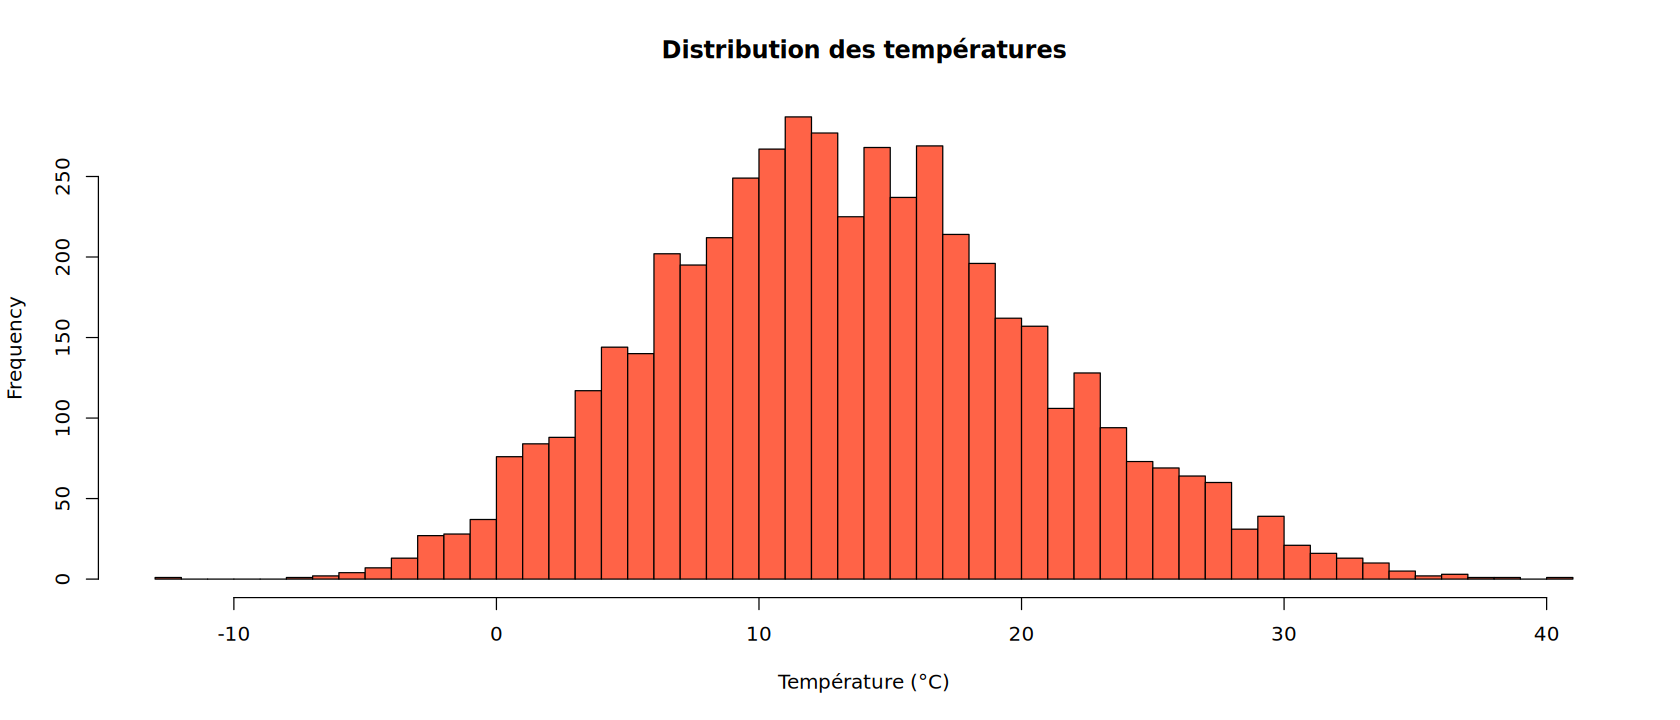

In [9]:
par(bg = 'white')
temp_sample_C <- temp_sample - 273.15
hist(temp_sample_C, breaks = 50, col = "tomato", main = "Distribution des températures", xlab = "Température (°C)")

In [10]:
observations$Date <- as.POSIXct(observations$Date,
                                format = "%Y-%m-%dT%H:%M:%S",
                                tz = "UTC")

temp_21dec <- observations %>%
  filter(format(Date, "%m-%d") == "12-21") %>%
  mutate(annee = format(Date, "%Y")) %>%
  group_by(annee) %>%
  summarise(temp_moy = mean(Température, na.rm = TRUE),
            .groups = "drop")

temp_21dec_moy <- temp_21dec$temp_moy
temp_21dec_moy <- scale(temp_21dec_moy)

shapiro.test(temp_21dec_moy)


	Shapiro-Wilk normality test

data:  temp_21dec_moy
W = 0.85084, p-value = 0.05944


## Régression 
### Matrice de corrélation


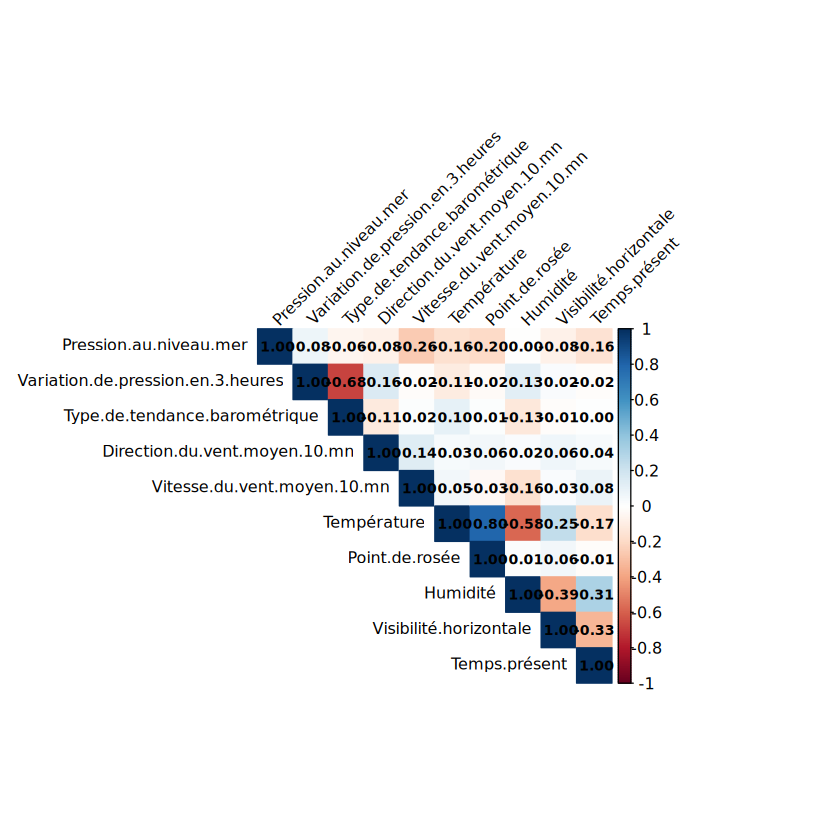

In [31]:
library(corrplot)
library(dplyr)
par(bg='white')
# Sélectionner uniquement les colonnes numériques
vars_num <- data_metropole %>% 
  select(where(is.numeric))

# Garder seulement les 10 premières colonnes numériques (optionnel)
vars_num <- vars_num[, 2:11]

# Corrélation
mat_cor <- cor(vars_num, use = "pairwise.complete.obs")

# Sauvegarde dans une grande image
# png("../fig/corrplot2.png", width = 1200, height = 1200, res = 150)

corrplot(mat_cor, method = "color", type = "upper",
         tl.col = "black", tl.srt = 45, 
         tl.cex = 0.8,         # taille du texte des labels
         addCoef.col = "black", 
         number.cex = 0.7)

# dev.off()


### Régression simple: moy_Humidté_mensuelle ~ moy_Température_mensuelle 

Afin de limiter les biais et de garantir une représentativité spatiale, nous avons sélectionné des stations météorologiques éloignées les unes des autres, réparties sur l’ensemble du territoire français :

* Nord : 7015 – Fretin (59, Hauts-de-France)
* Centre : 7149 – Athis-Mons (91, Essonne, Île-de-France)
* Ouest : 7110 – Guipavas (29, Finistère)
* Est : 7190 – Holtzheim (67, Bas-Rhin)
* Sud-Ouest : 7630 – Blagnac (31, Haute-Garonne). »

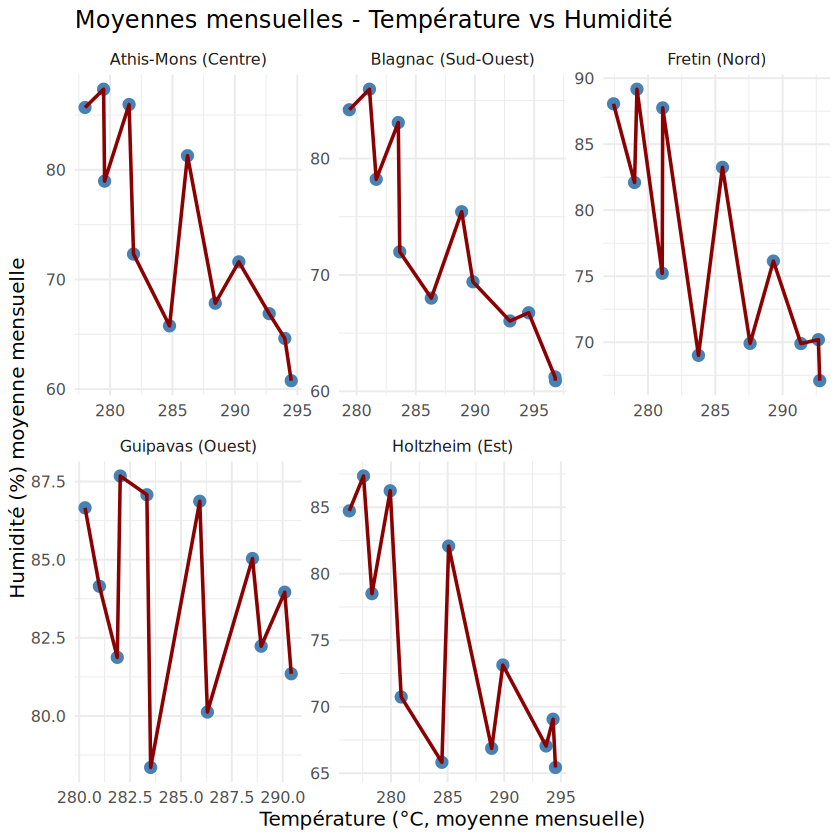

In [32]:
par(bg='white')
library(dplyr)
library(ggplot2)

stations_a_comparer <- c(7015, 7149, 7110, 7190, 7630)

# Dictionnaire ID → Nom
station_labels <- c(
  "7015" = "Fretin (Nord)",
  "7149" = "Athis-Mons (Centre)",
  "7110" = "Guipavas (Ouest)",
  "7190" = "Holtzheim (Est)",
  "7630" = "Blagnac (Sud-Ouest)"
)

# Calculer la moyenne mensuelle par station
data_monthly <- data_metropole %>%
  filter(ID.OMM.station %in% stations_a_comparer) %>%
  group_by(ID.OMM.station, mois_de_l_annee) %>%
  summarise(
    Température_moy = mean(Température, na.rm = TRUE),
    Humidité_moy = mean(Humidité, na.rm = TRUE),
    .groups = "drop"
  )

# Ajouter noms des stations
data_monthly <- data_monthly %>%
  mutate(Station = recode(as.character(ID.OMM.station), !!!station_labels))

# Plot
ggplot(data_monthly, aes(x = Température_moy, y = Humidité_moy)) +
  geom_point(color = "steelblue", size = 3) +
  geom_line(color = "darkred", size = 1) +
  theme_minimal(base_size = 12) +
  labs(title = "Moyennes mensuelles - Température vs Humidité",
       x = "Température (°C, moyenne mensuelle)",
       y = "Humidité (%) moyenne mensuelle") +
  facet_wrap(~ Station, scales = "free")



`geom_smooth()` using formula = 'y ~ x'


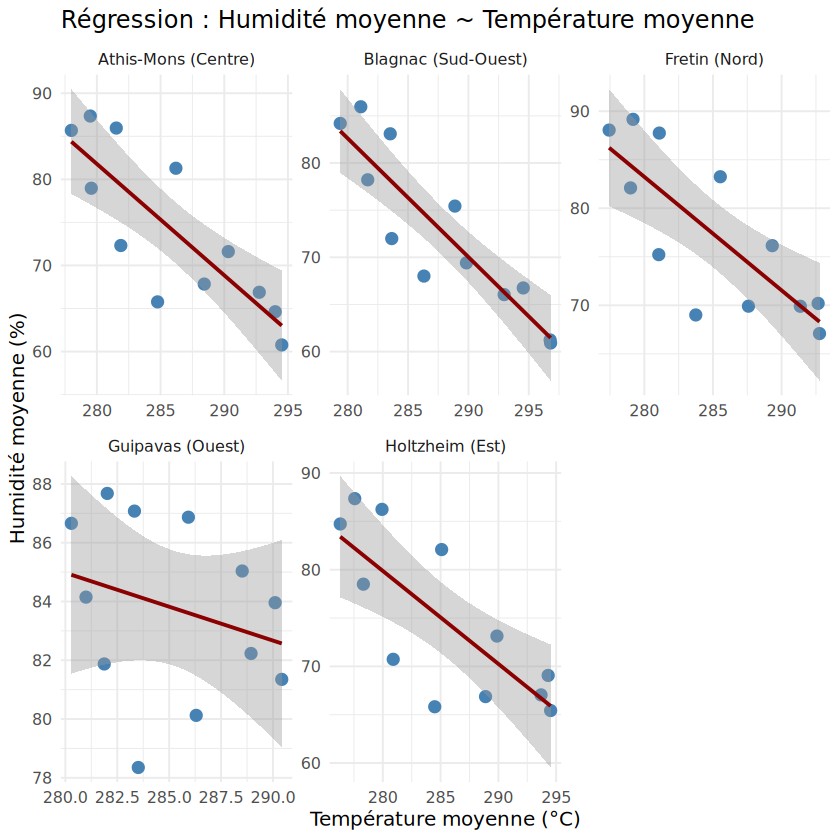

In [35]:
library(dplyr)
library(ggplot2)

stations_a_comparer <- c(7015, 7149, 7110, 7190, 7650, 7630)

# Dictionnaire ID → Nom de station
station_labels <- c(
  "7015" = "Fretin (Nord)",
  "7149" = "Athis-Mons (Centre)",
  "7110" = "Guipavas (Ouest)",
  "7190" = "Holtzheim (Est)",
  "7650" = "Marignane (Sud-Est)",
  "7630" = "Blagnac (Sud-Ouest)"
)

# 1. Calculer les moyennes mensuelles de Température et Humidité par station
data_monthly <- data_metropole %>%
  filter(ID.OMM.station %in% stations_a_comparer) %>%
  group_by(ID.OMM.station, mois_de_l_annee) %>%
  summarise(
    Temp_moy = mean(Température, na.rm = TRUE),
    Humid_moy = mean(Humidité, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  # Ajouter le nom des stations
  mutate(Station = recode(as.character(ID.OMM.station), !!!station_labels))

# 2. Plot avec régression linéaire par station
ggplot(data_monthly, aes(x = Temp_moy, y = Humid_moy)) +
  geom_point(color = "steelblue", size = 3) +
  geom_smooth(method = "lm", se = TRUE, color = "darkred") +
  theme_minimal(base_size = 12) +
  labs(title = "Régression : Humidité moyenne ~ Température moyenne",
       x = "Température moyenne (°C)",
       y = "Humidité moyenne (%)") +
  facet_wrap(~ Station, scales = "free")



Les régressions confirment une tendance physique attendue : hausse de la température ↔ baisse de l’humidité relative, avec une intensité différente selon les régions (plus forte en climat continental, plus atténuée en climat océanique).
Cependant, il faut rester prudent : l’usage de moyennes mensuelles, d’un modèle linéaire et l’absence de prise en compte de la saisonnalité limitent la portée explicative de ces résultats.

### Régression multiple:Visibilité_moy ~ Humidité + Température +Pression au niveau de la mer + Précipitations au 24h

L’objectif est de modéliser et d’expliquer la visibilité moyenne (Visibilité_moy) en fonction de plusieurs paramètres météorologiques. 
L’idée est de déterminer quels facteurs influencent le plus la visibilité et d’évaluer leur contribution relative. 

In [42]:
library(dplyr)

# ---- Préparation des données ----

# 1. Ajouter année et saison
data_metropole <- data_metropole %>%
  mutate(
    annee = format(as.Date(substr(Date, 1, 10)), "%Y"),
    saison = case_when(
      mois_de_l_annee %in% c(12, 1, 2)  ~ "Hiver",
      mois_de_l_annee %in% c(3, 4, 5)   ~ "Printemps",
      mois_de_l_annee %in% c(6, 7, 8)   ~ "Été",
      mois_de_l_annee %in% c(9, 10, 11) ~ "Automne"
    )
  )

# 2. Moyennes saisonnières par station et année
data_yearly <- data_metropole %>%
  group_by(ID.OMM.station, annee, saison) %>%
  summarise(
    Visib_moy   = mean(`Visibilité.horizontale`, na.rm = TRUE),
    Humid_moy   = mean(`Humidité`, na.rm = TRUE),
    Temp_moy    = mean(`Température`, na.rm = TRUE),
    Pression    = mean(`Pression.au.niveau.mer`, na.rm = TRUE),
    Precip_24h  = mean(`Précipitations.dans.les.24.dernières.heures`, na.rm = TRUE),
    .groups = "drop"
  )

# 3. Centrer et réduire les prédicteurs
data_yearly <- data_yearly %>%
  mutate(
    Humid_scaled    = scale(Humid_moy, center = TRUE, scale = TRUE)[,1],
    Temp_scaled     = scale(Temp_moy, center = TRUE, scale = TRUE)[,1],
    Pression_scaled = scale(Pression, center = TRUE, scale = TRUE)[,1],
    Precip_scaled   = scale(Precip_24h, center = TRUE, scale = TRUE)[,1]
  )


# A tibble: 20 × 6
   term            estimate std.error statistic   p.value Saison   
   <chr>              <dbl>     <dbl>     <dbl>     <dbl> <chr>    
 1 (Intercept)       27638.     1127.    24.5   7.79e- 82 Hiver    
 2 Humid_scaled      -6951.      580.   -12.0   1.82e- 28 Hiver    
 3 Temp_scaled         336.      914.     0.368 7.13e-  1 Hiver    
 4 Pression_scaled    -112.      371.    -0.302 7.63e-  1 Hiver    
 5 Precip_scaled      -216.      460.    -0.471 6.38e-  1 Hiver    
 6 (Intercept)       25130.      740.    34.0   6.58e-115 Printemps
 7 Humid_scaled      -4892.      641.    -7.63  2.13e- 13 Printemps
 8 Temp_scaled        7603.     1411.     5.39  1.27e-  7 Printemps
 9 Pression_scaled   -1083.      545.    -1.99  4.76e-  2 Printemps
10 Precip_scaled      1938.      636.     3.04  2.50e-  3 Printemps
11 (Intercept)       15684.     1730.     9.07  5.52e- 18 Été      
12 Humid_scaled      -2289.      663.    -3.45  6.13e-  4 Été      
13 Temp_scaled        8049.  

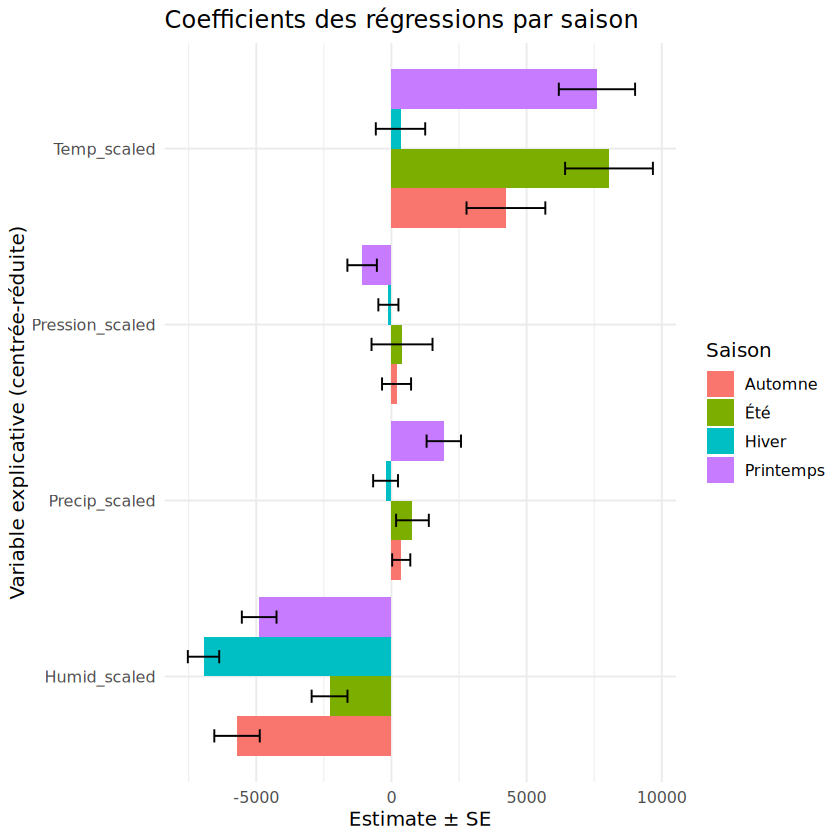

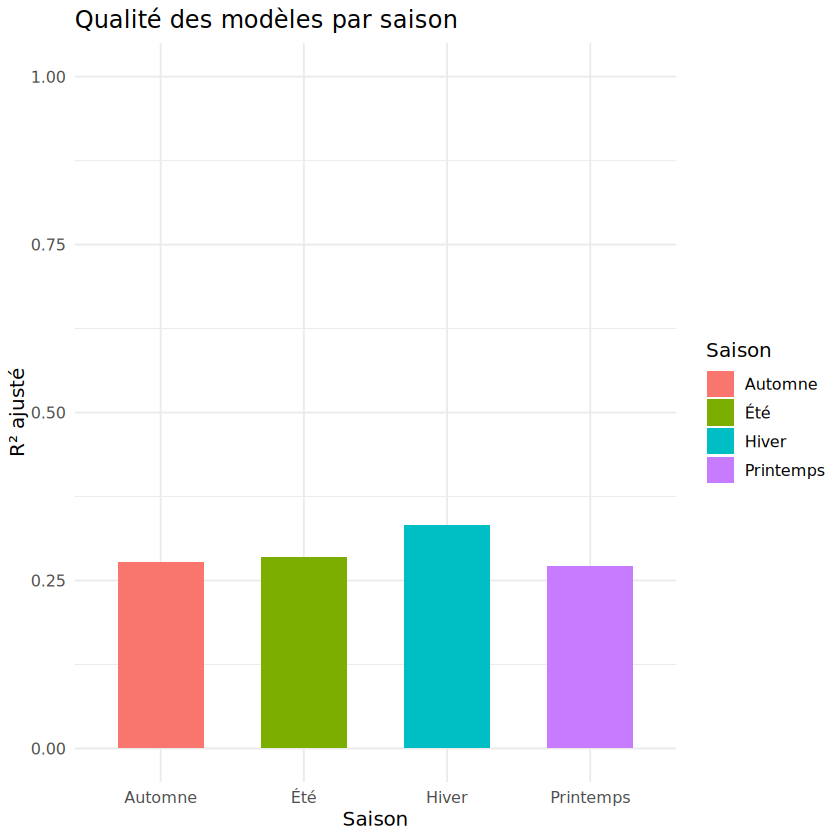

In [43]:
library(dplyr)
library(broom)   # pour tidy() et glance()

# 1. Fonction qui ajuste et retourne les résultats
fit_model <- function(saison_name) {
  d <- filter(data_yearly, saison == saison_name)
  modele <- lm(Visib_moy ~ Humid_scaled + Temp_scaled + Pression_scaled + Precip_scaled,
               data = d)
  tidy_res   <- broom::tidy(modele) %>% mutate(Saison = saison_name)
  glance_res <- broom::glance(modele) %>% mutate(Saison = saison_name)
  list(tidy = tidy_res, glance = glance_res)
}

# 2. Ajuster les 4 modèles
res_hiver     <- fit_model("Hiver")
res_printemps <- fit_model("Printemps")
res_ete       <- fit_model("Été")
res_automne   <- fit_model("Automne")

# 3. Rassembler les coefficients
coef_all <- bind_rows(res_hiver$tidy, res_printemps$tidy, 
                      res_ete$tidy, res_automne$tidy)

# 4. Rassembler les métriques globales (R², AIC, etc.)
stats_all <- bind_rows(res_hiver$glance, res_printemps$glance,
                       res_ete$glance, res_automne$glance)

# 👉 Afficher
print(coef_all)   # détails des coefficients par saison
print(stats_all)  # qualité globale par saison
library(ggplot2)

# ---- 1. Plot des coefficients par saison ----
ggplot(coef_all %>% filter(term != "(Intercept)"),
       aes(x = term, y = estimate, fill = Saison)) +
  geom_col(position = "dodge") +
  geom_errorbar(aes(ymin = estimate - std.error,
                    ymax = estimate + std.error),
                position = position_dodge(width = 0.9), width = 0.3) +
  theme_minimal(base_size = 12) +
  labs(title = "Coefficients des régressions par saison",
       x = "Variable explicative (centrée-réduite)",
       y = "Estimate ± SE") +
  coord_flip()

# ---- 2. Plot des R² ajustés par saison ----
ggplot(stats_all, aes(x = Saison, y = adj.r.squared, fill = Saison)) +
  geom_col(width = 0.6) +
  theme_minimal(base_size = 12) +
  labs(title = "Qualité des modèles par saison",
       x = "Saison",
       y = "R² ajusté") +
  ylim(0, 1)


La première figure montre l’effet des variables météo sur la visibilité selon la saison.

* **Humidité** : impact négatif net, surtout en hiver et automne (brouillard, air saturé).
* **Température** : effet positif marqué au printemps et en été (air plus sec, meilleure visibilité).
* **Pression et précipitations** : effets faibles ou non significatifs.

Globalement, la visibilité est surtout conditionnée par l’humidité (réduction) et la température (amélioration).

La deuxième figure montre la qualité des modèles par saison via le R² ajusté.

Commentaire concis :

Les modèles expliquent environ 25 à 35 % de la variabilité de la visibilité, avec des performances légèrement meilleures en hiver. Cela indique que les variables météo incluses (température, humidité, pression, précipitations) capturent une partie de l’effet, mais qu’une grande part de la variabilité reste inexpliquée.

Warning message:
“Removed 12 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 11 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 12 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 12 rows containing missing values or values outside the scale range
(`geom_point()`).”


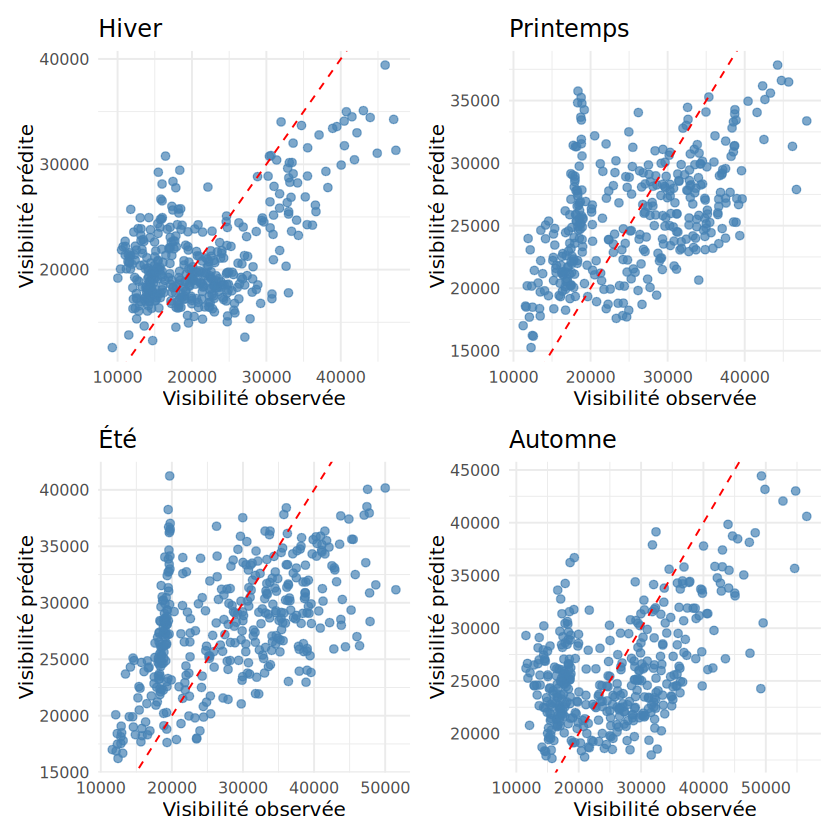

In [ ]:
# ---- Fonction pour ajuster un modèle et créer un plot ----
fit_plot <- function(saison_name) {
  d <- filter(data_yearly, saison == saison_name)
  
  # Ajuster la régression
  modele <- lm(Visib_moy ~ Humid_scaled + Temp_scaled + Pression_scaled + Precip_scaled,
               data = d)
  
  # Ajouter les prédictions
  d$Pred <- predict(modele, newdata = d)
  
  # Scatter plot Observé vs Prédit
  ggplot(d, aes(x = Visib_moy, y = Pred)) +
    geom_point(color = "steelblue", size = 2, alpha = 0.7) +
    geom_abline(slope = 1, intercept = 0, color = "red", linetype = "dashed") +
    theme_minimal(base_size = 12) +
    labs(
      title = saison_name,
      x = "Visibilité observée",
      y = "Visibilité prédite"
    )
}

# ---- Générer les 4 plots ----
plot_hiver     <- fit_plot("Hiver")
plot_printemps <- fit_plot("Printemps")
plot_ete       <- fit_plot("Été")
plot_automne   <- fit_plot("Automne")

# ---- Afficher en grille 2x2 ----
(plot_hiver | plot_printemps) / (plot_ete | plot_automne)


ces graphiques montrent que les modèles expliquent correctement la tendance générale de la visibilité,
surtout en hiver, mais restent imparfaits, avec une tendance à sous-estimer les fortes visibilités 
et une dispersion notable dans les autres saisons.

# ACP

In [44]:
source('acp.R')

### ACP pour une station (NICE)

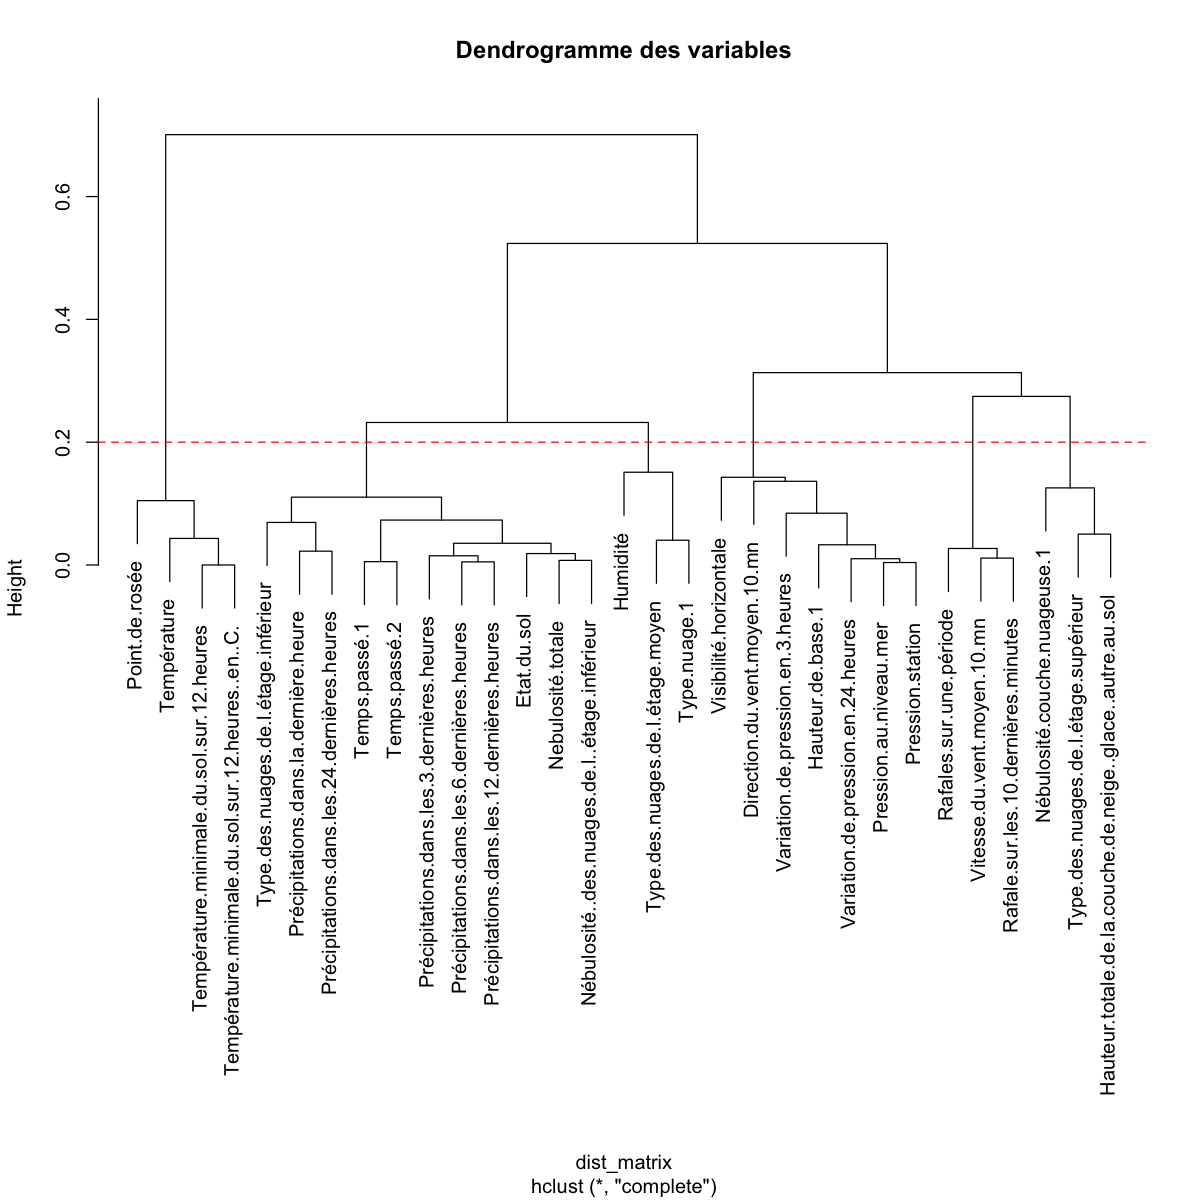

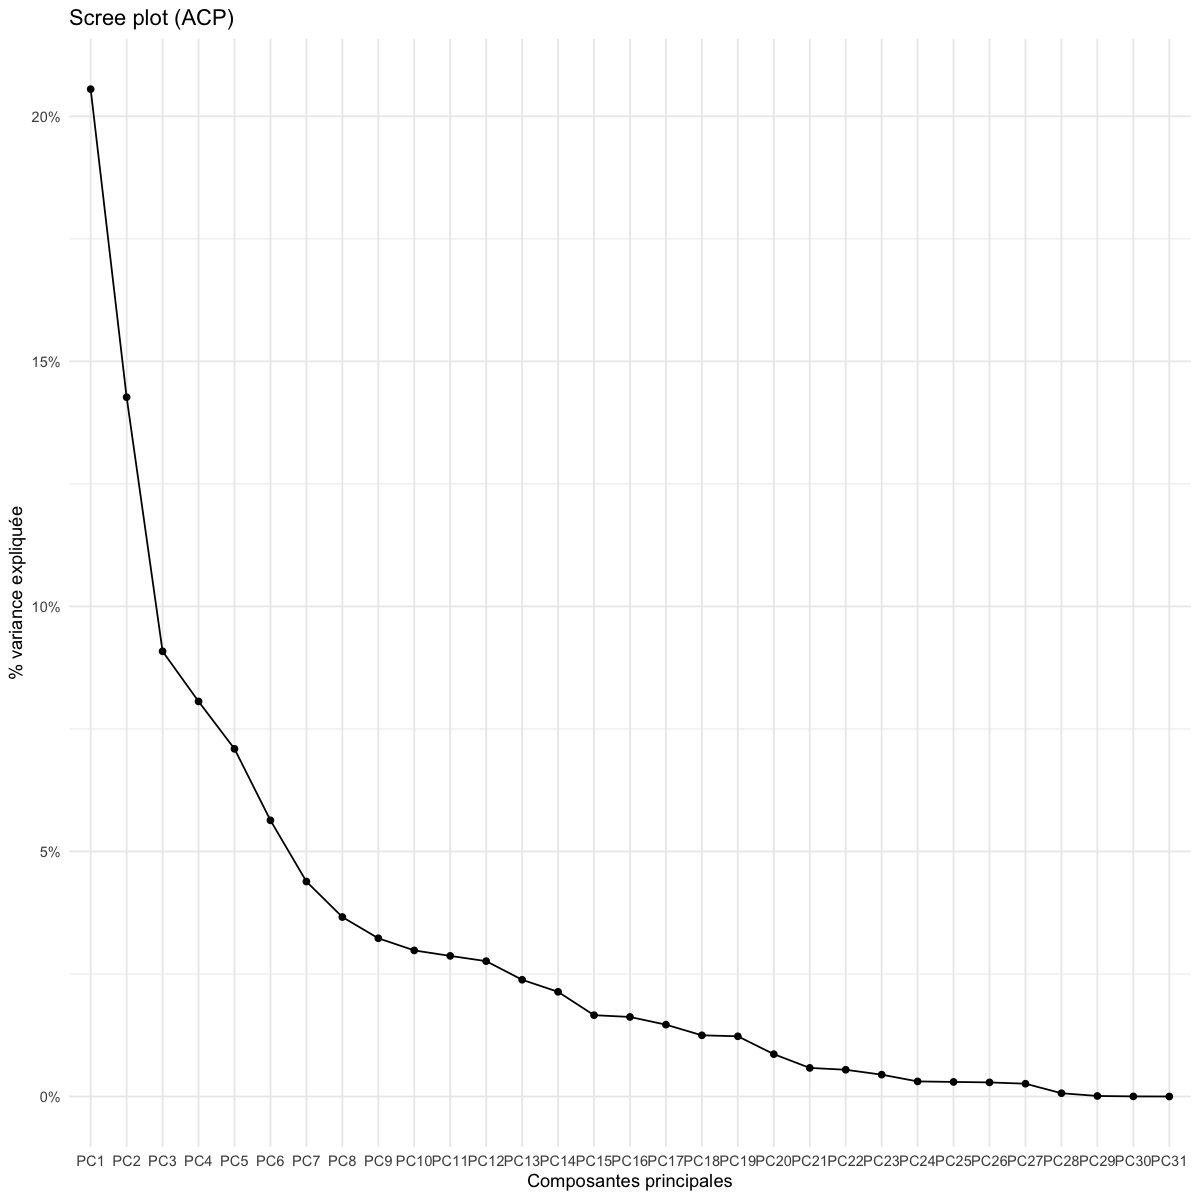

In [48]:
# Définir l'ID de la station
id <- 7690

# Construire le chemin et le préfixe dynamiquement
file_path   <- paste0("../csv/station_", id, "_obs_cleaned.csv")

# Appel de la fonction
res <- pca_with_season_plots(
  file_path      = file_path,
  seuil_distance = 0.2,
)
# Afficher les graphiques dans R

res$plots$scree


Les deux première composantes principales expliquent environ 35% de la variance, ce qui ne permer d'avoir une visualisation lisible en 2D.

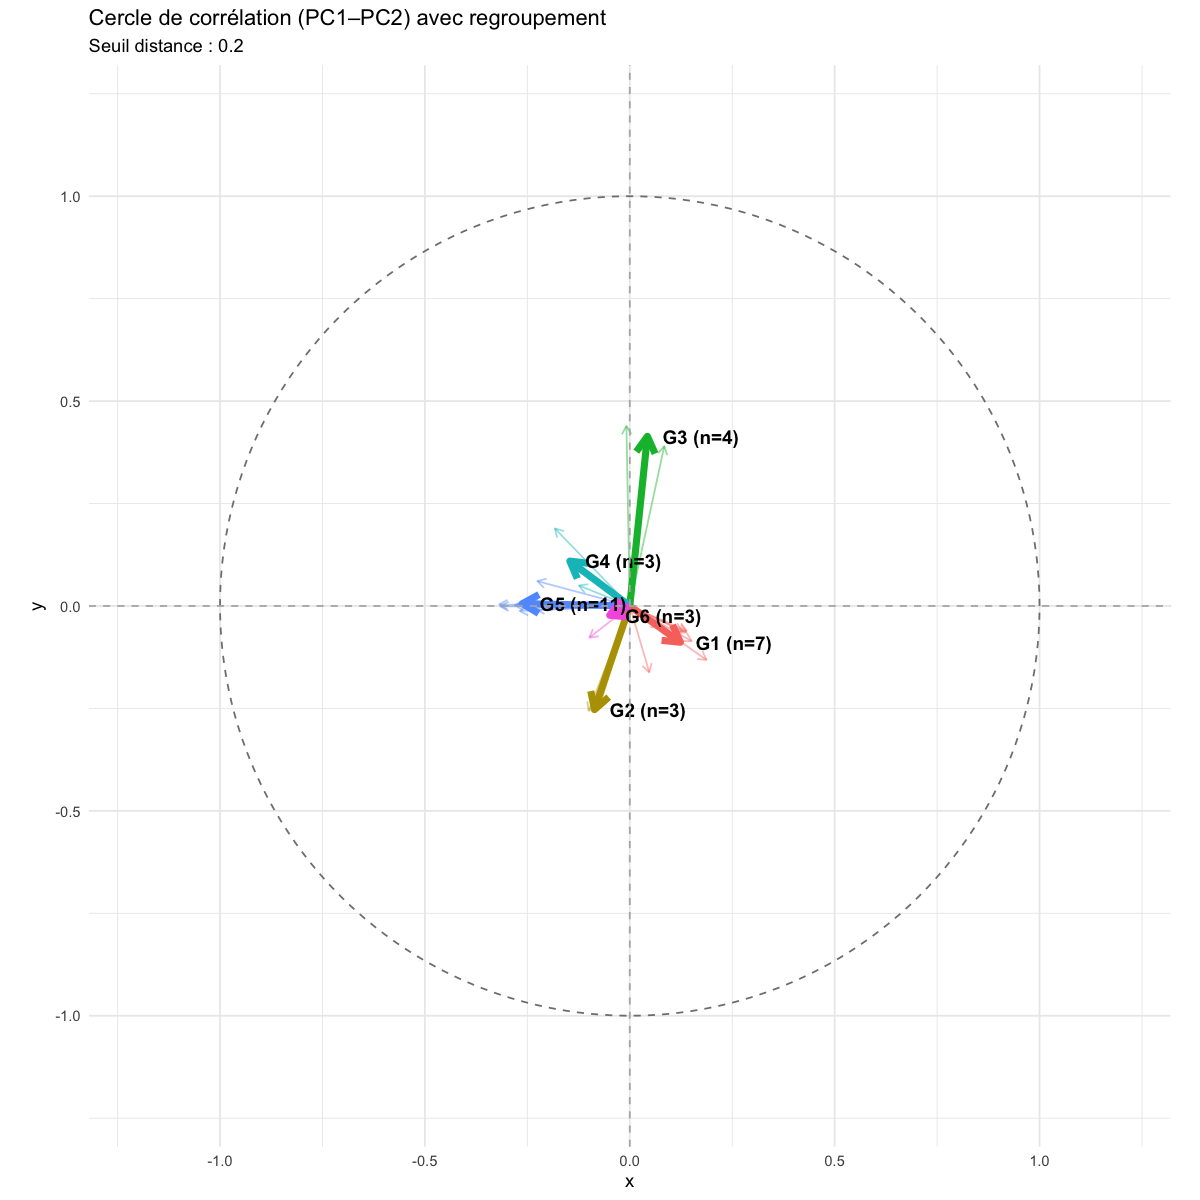

In [46]:
res$plots$circle

Nous avons fait des groupes de variables puisqu'au total 31 variables étaient considérées pour cette station ce qui diminuait nettement la visiblité du graphique des projections des variables dans le plan principal

In [49]:
groupes = res$groupes
loadings_df = res$loadings
  cat("\n=== Détail des groupes ===\n")
    for(g in unique(groupes)) {
    cat("\nGroupe", g, ":\n")
    vars_g <- loadings_df$var[loadings_df$groupe == g]
    cat(paste(vars_g, collapse = "\n"), "\n")
  }


=== Détail des groupes ===

Groupe 1 :
Pression.au.niveau.mer
Variation.de.pression.en.3.heures
Direction.du.vent.moyen.10.mn
Visibilité.horizontale
Pression.station
Variation.de.pression.en.24.heures
Hauteur.de.base.1 

Groupe 2 :
Vitesse.du.vent.moyen.10.mn
Rafale.sur.les.10.dernières.minutes
Rafales.sur.une.période 

Groupe 3 :
Température
Point.de.rosée
Température.minimale.du.sol.sur.12.heures
Température.minimale.du.sol.sur.12.heures..en..C. 

Groupe 4 :
Humidité
Type.des.nuages.de.l.étage.moyen
Type.nuage.1 

Groupe 5 :
Temps.passé.1
Temps.passé.2
Nebulosité.totale
Nébulosité..des.nuages.de.l..étage.inférieur
Type.des.nuages.de.l.étage.inférieur
Etat.du.sol
Précipitations.dans.la.dernière.heure
Précipitations.dans.les.3.dernières.heures
Précipitations.dans.les.6.dernières.heures
Précipitations.dans.les.12.dernières.heures
Précipitations.dans.les.24.dernières.heures 

Groupe 6 :
Type.des.nuages.de.l.étage.supérieur
Hauteur.totale.de.la.couche.de.neige..glace..autre.au.sol
Nébulo

Nous avons ensuite représenté les observations dans le plan principal coloré par saison

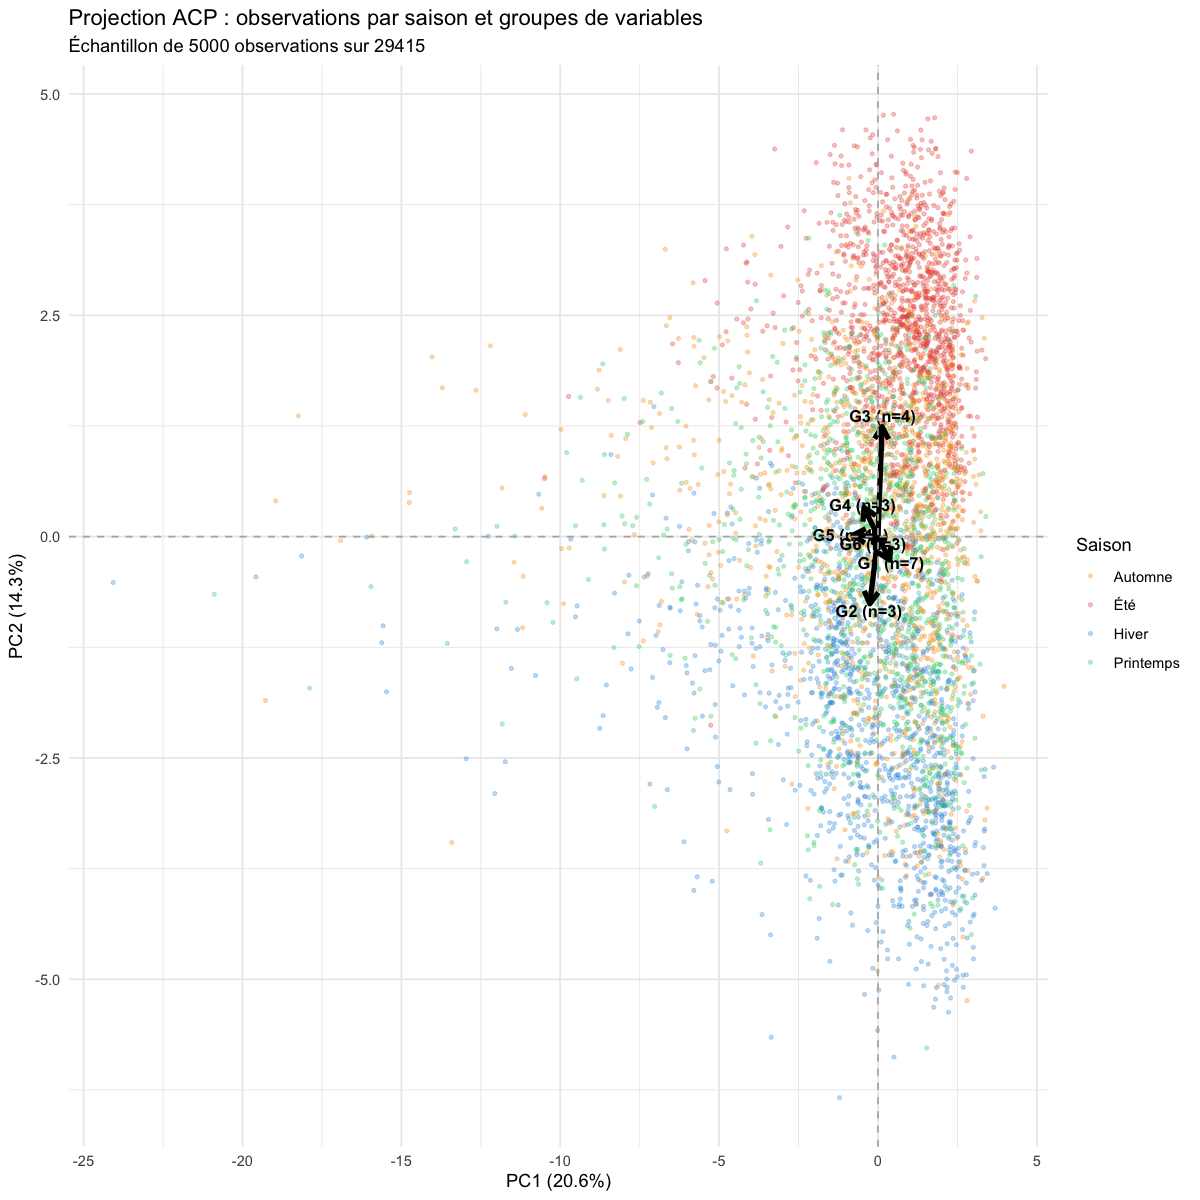

In [52]:
res$plots$all_seasons


On passe progressivement de l'hiver vers l'été en suivant l'axe principale PC2. Les variables aident le plus à séparer les groupes étant le groupe 3, lié à la température et le groupe 4 ne comprenant que l'humidité.
C'est cohérent puisque l'humidité augmente en hiver et température augmente en été et inversement.

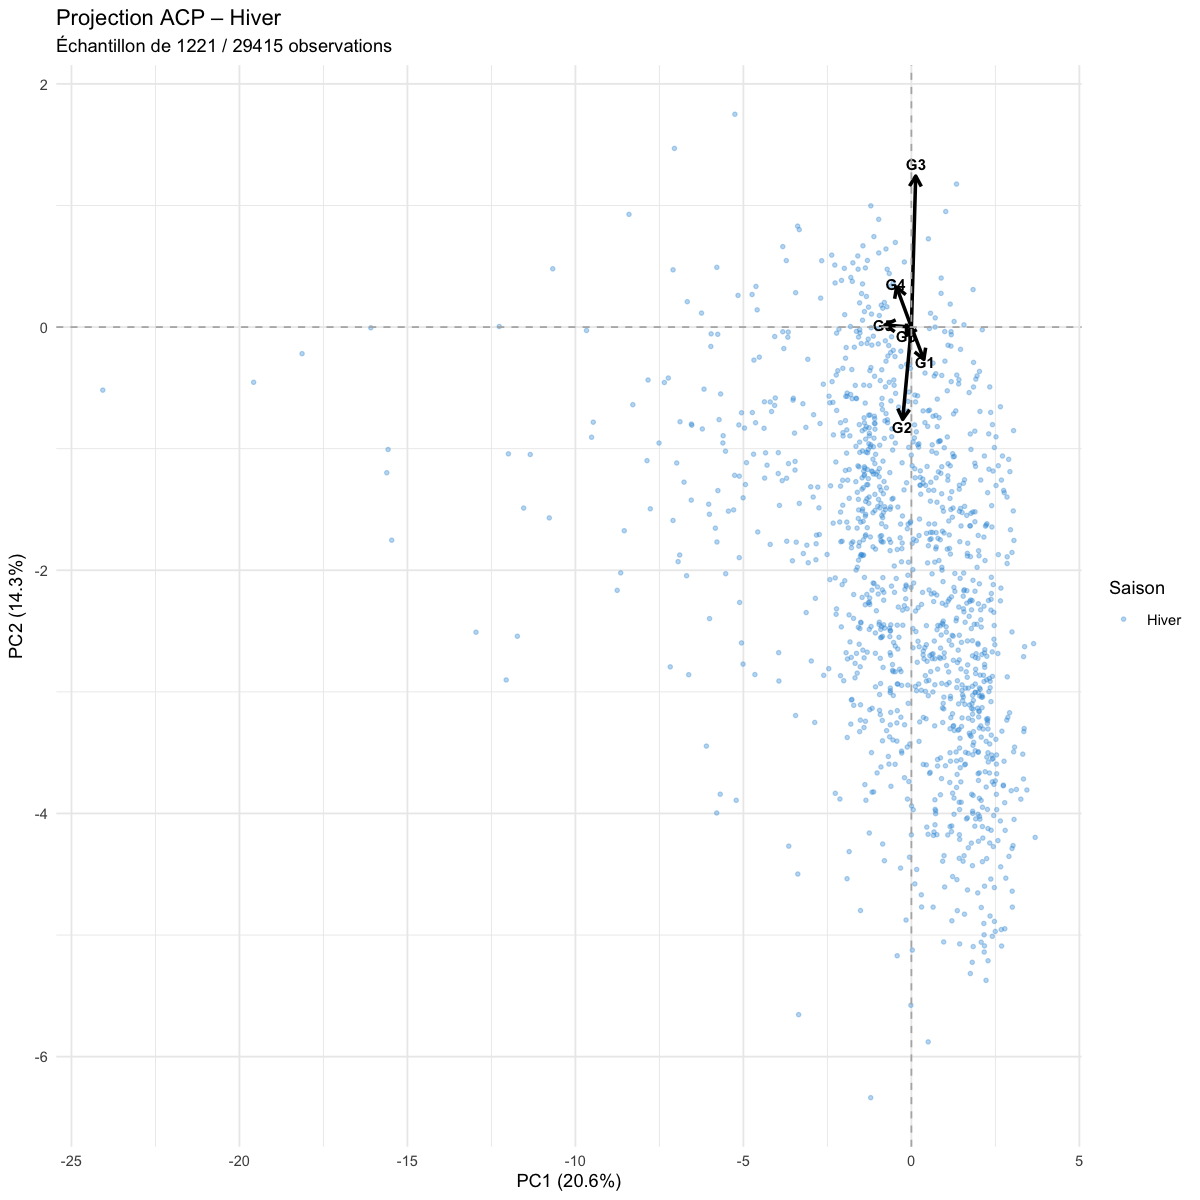

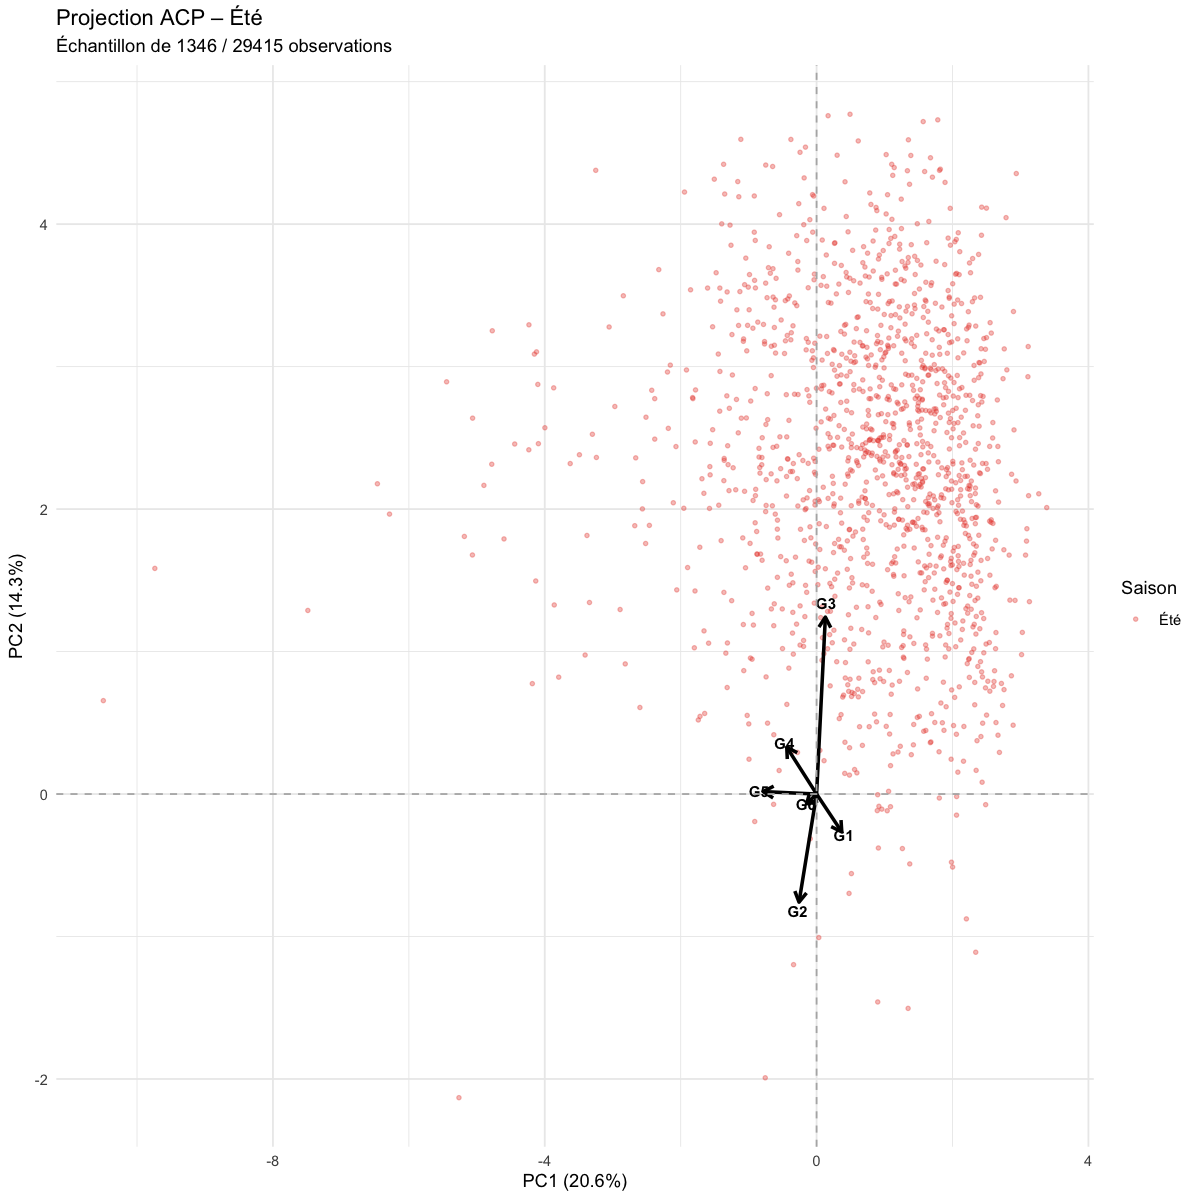

In [53]:
res$plots$by_season$Hiver
res$plots$by_season$`Été`

En faisant deux graphiques séparés on observe plus nettement la séparation entre les deux saisons.

# AFD

A partir des labels obtenus des 4 saisons nous avons essayé de faire une AFD pour chercher les directions qui permettaient au mieux de discriminer les observations selon les saisons.
Nous avons réalisé cette dernière sur l'ensemble des données d'observations.

In [58]:
source('adf.R')

In [61]:
file_path   <- paste0("../csv/observations_cleaned.csv")

res_afd <- afd_with_season_plots(
  file_path      = file_path,
  seuil_distance = 0.2,
)

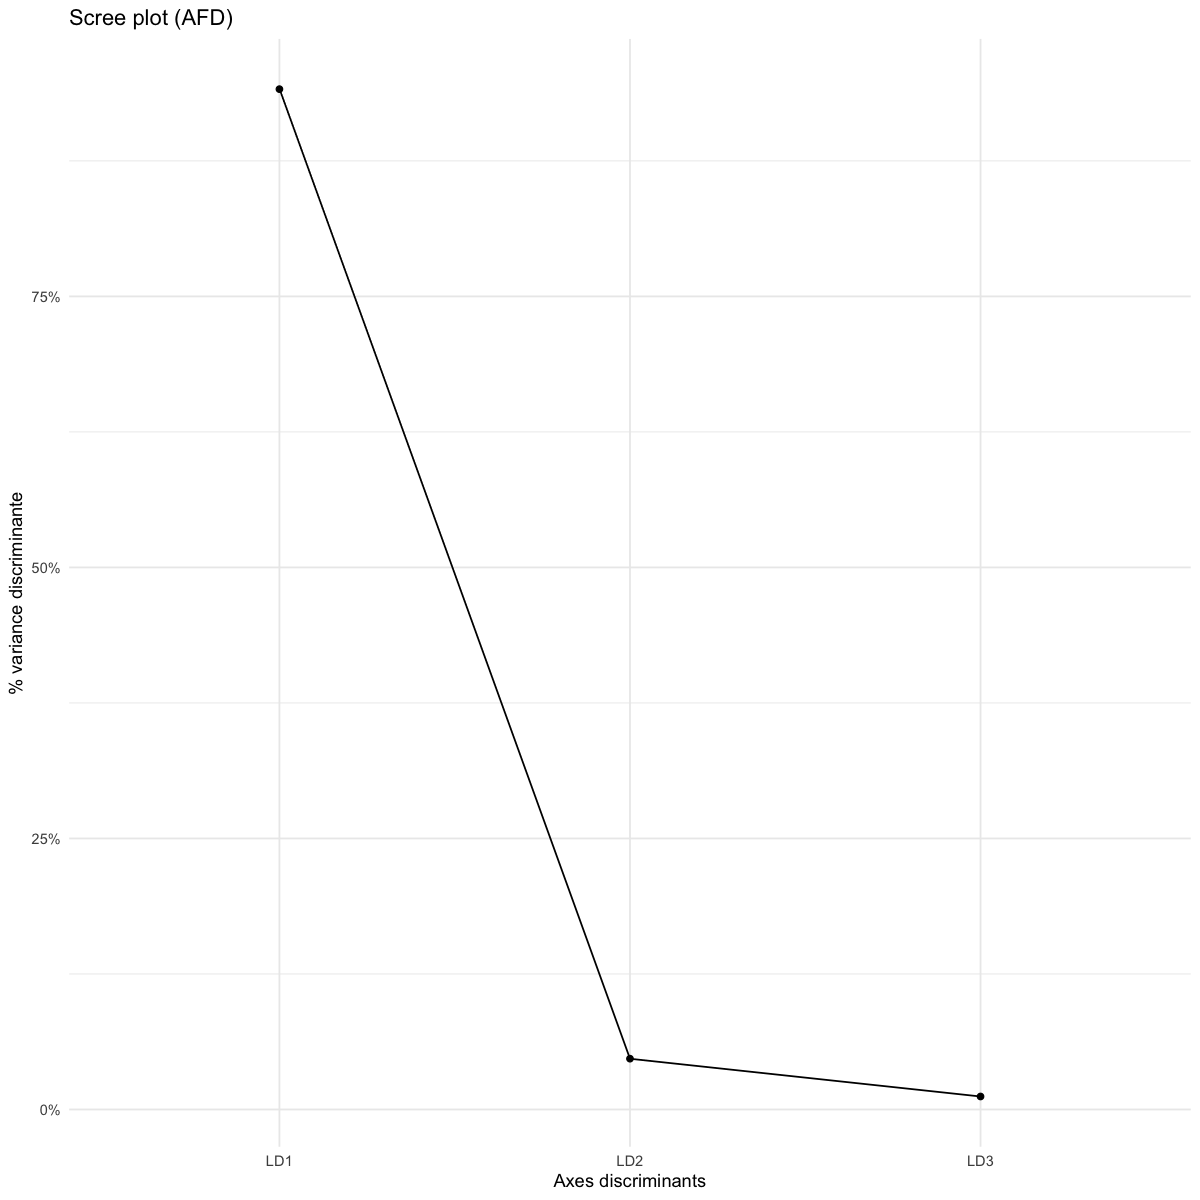

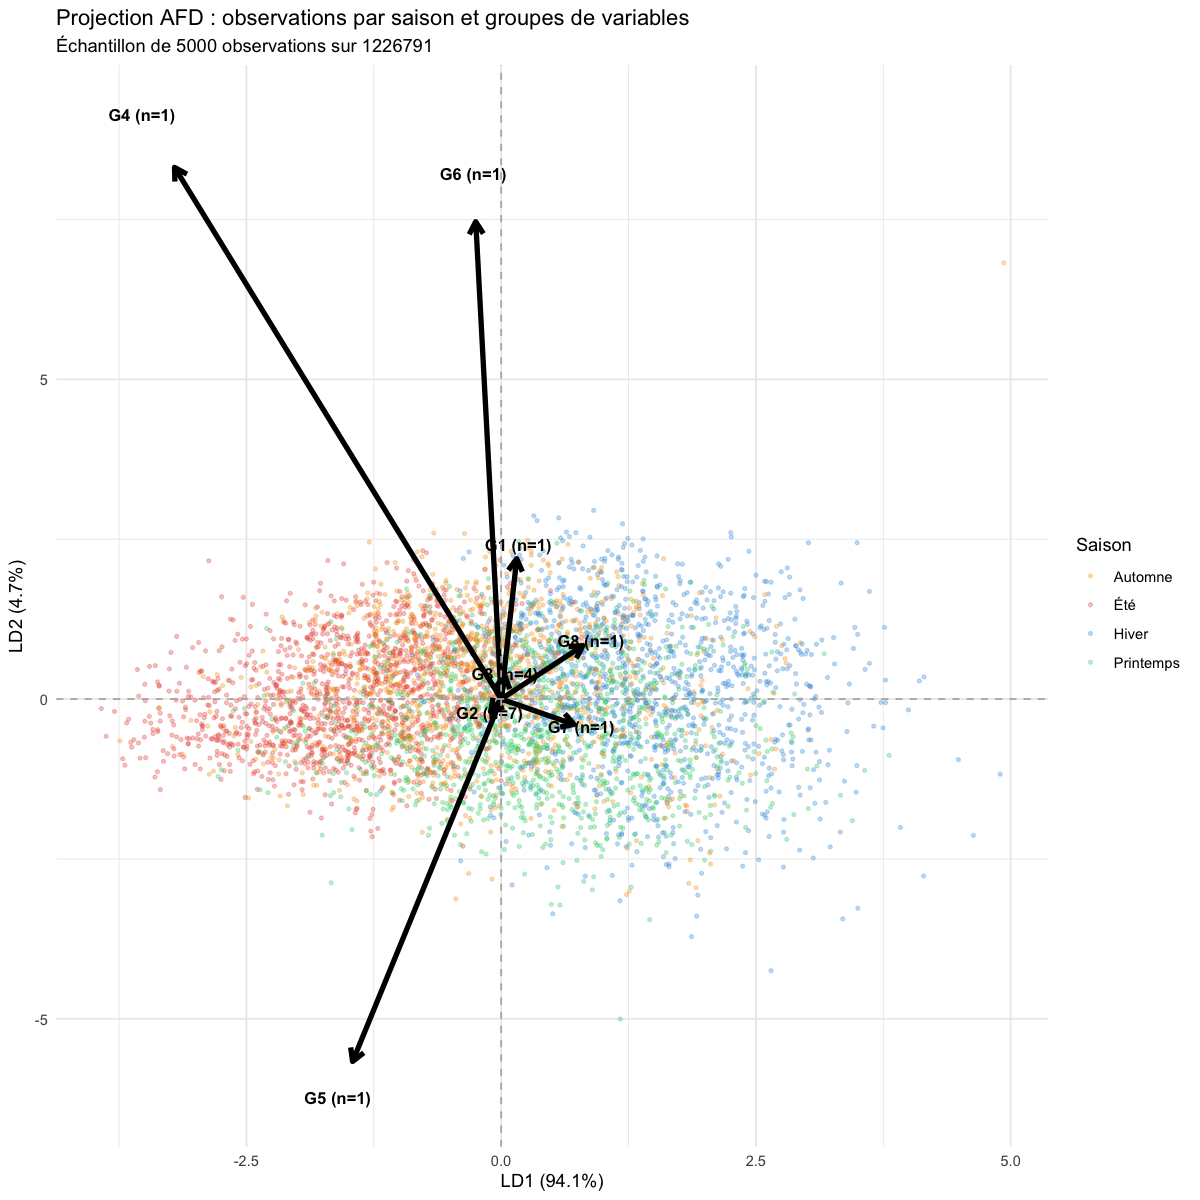

In [ ]:
res_afd$plots$scree
res_afd$plots$all_seasons

Le premier axe discriminant permet d'expliquer la variance inter-groupes à 94,1%, on aurait presque pu faire un visualisaiton en 1D pour discriminer les saisons

$`1`
[1] "Pression.au.niveau.mer"

$`2`
[1] "Variation.de.pression.en.3.heures"          
[2] "Vitesse.du.vent.moyen.10.mn"                
[3] "Variation.de.pression.en.24.heures"         
[4] "Précipitations.dans.la.dernière.heure"      
[5] "Précipitations.dans.les.3.dernières.heures" 
[6] "Précipitations.dans.les.6.dernières.heures" 
[7] "Précipitations.dans.les.12.dernières.heures"

$`3`
[1] "Direction.du.vent.moyen.10.mn"              
[2] "Visibilité.horizontale"                     
[3] "Rafale.sur.les.10.dernières.minutes"        
[4] "Précipitations.dans.les.24.dernières.heures"

$`4`
[1] "Température"

$`5`
[1] "Point.de.rosée"

$`6`
[1] "Humidité"

$`7`
[1] "Pression.station"

$`8`
[1] "Rafales.sur.une.période"

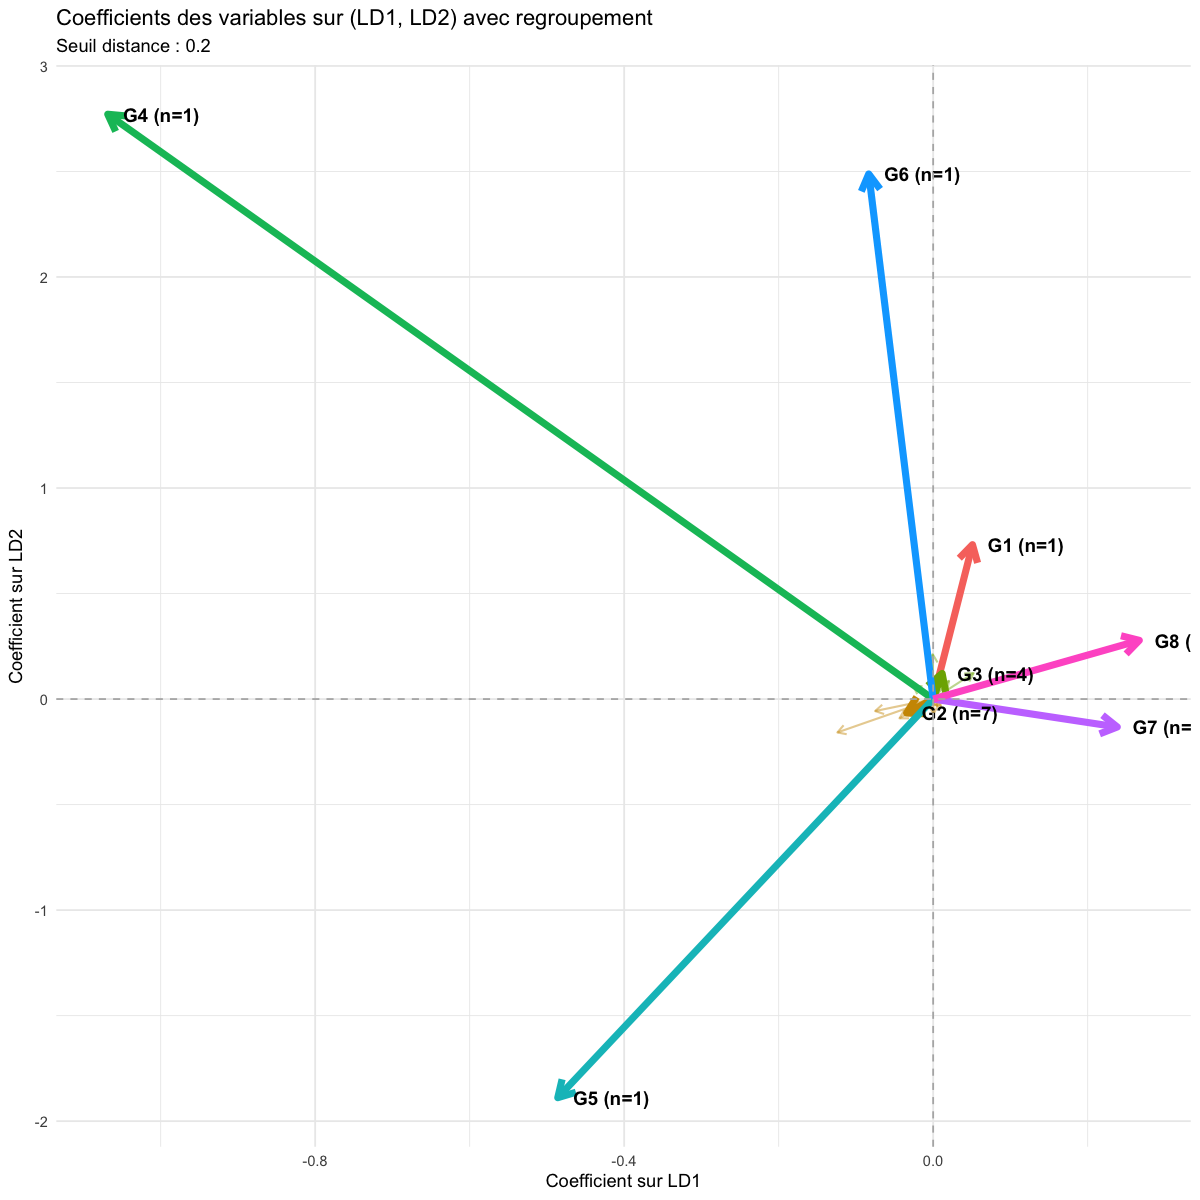

In [68]:
res_afd$plots$coefficients
res_afd$groupes

Pour améliorer la lisibilité du graphique, nous avons également réalisé un clustering des variables exprimées dans le plan principal.

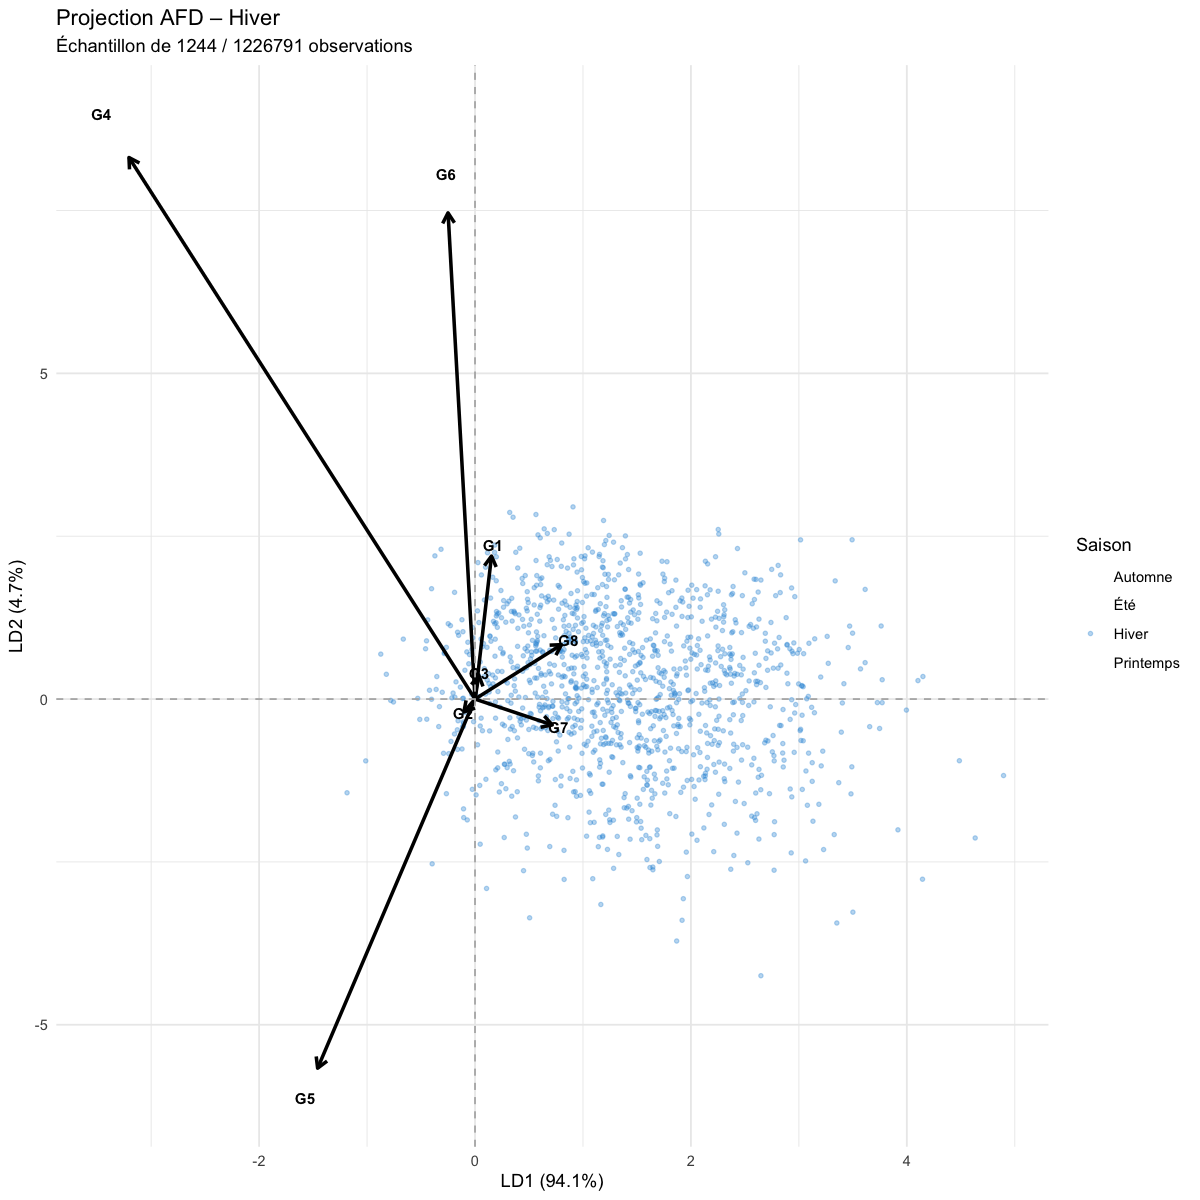

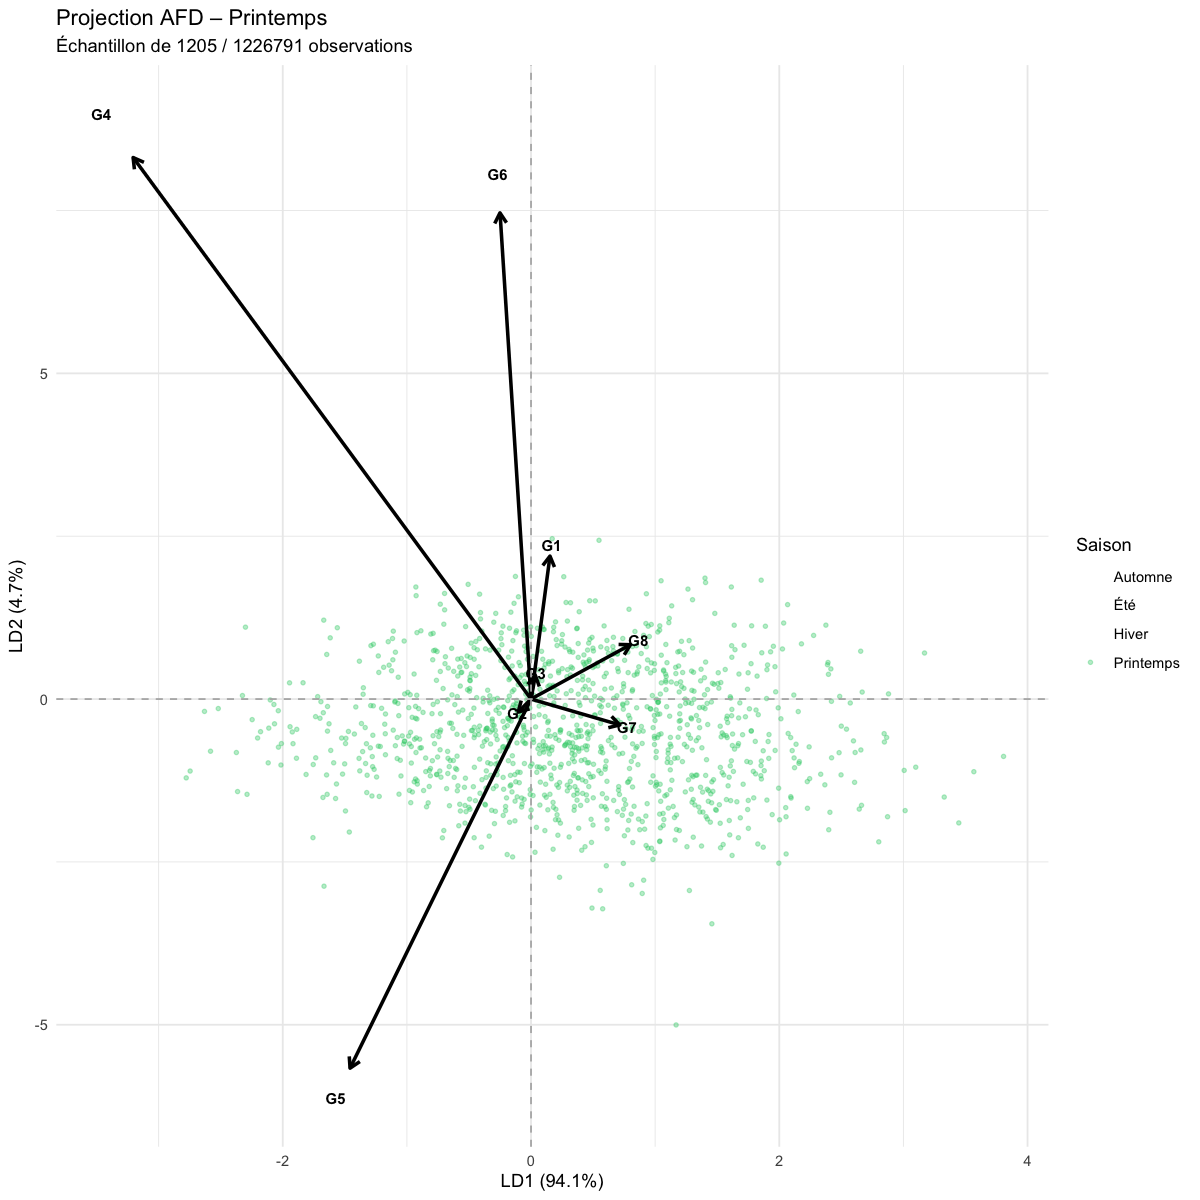

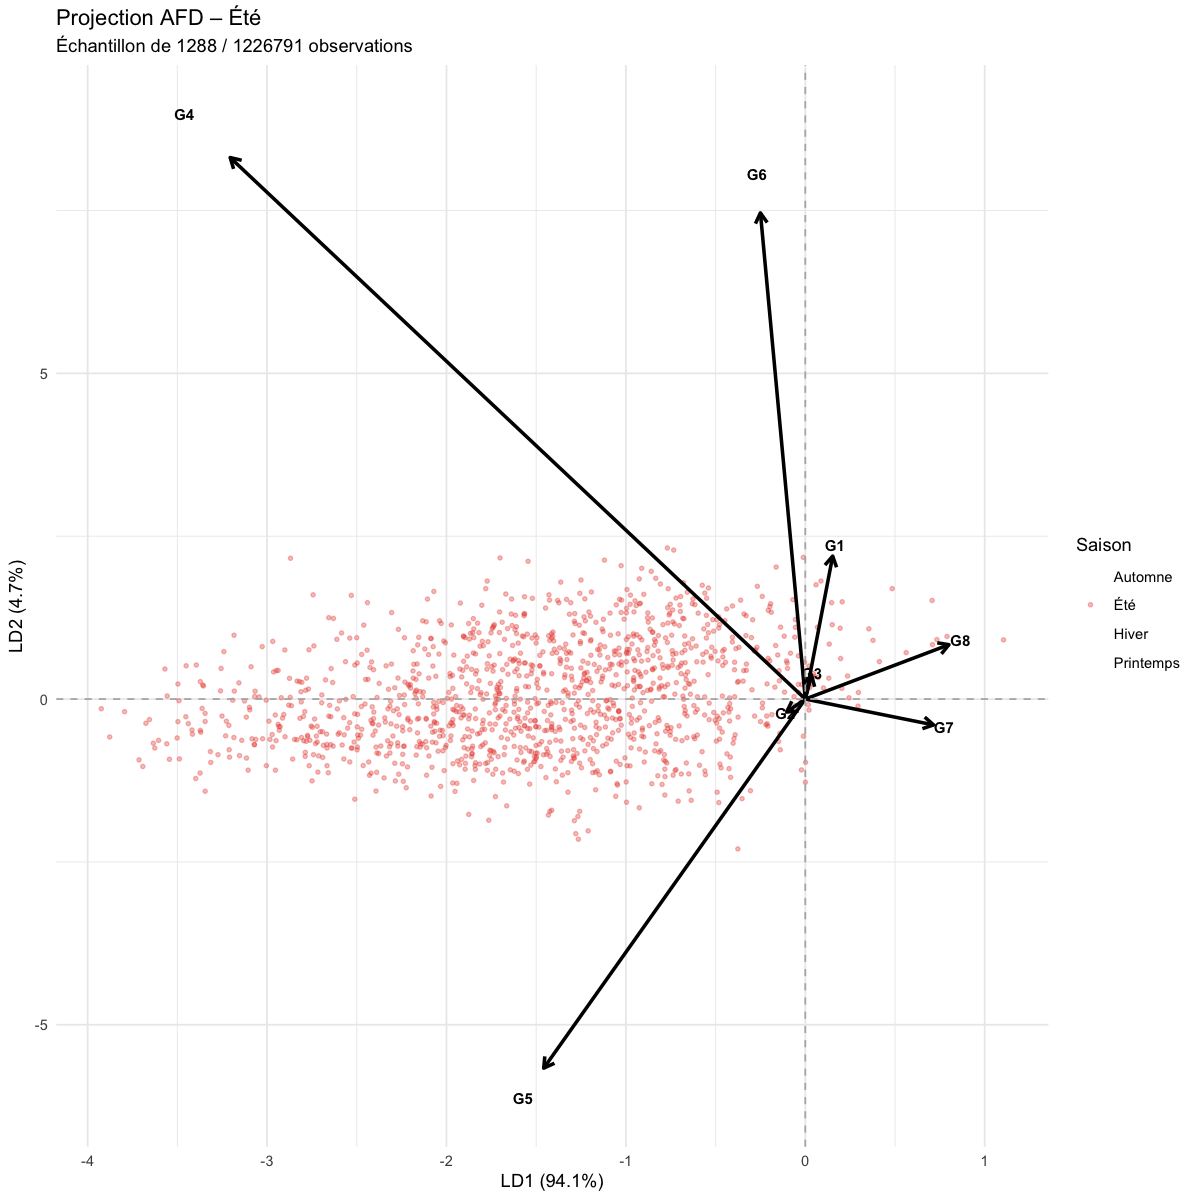

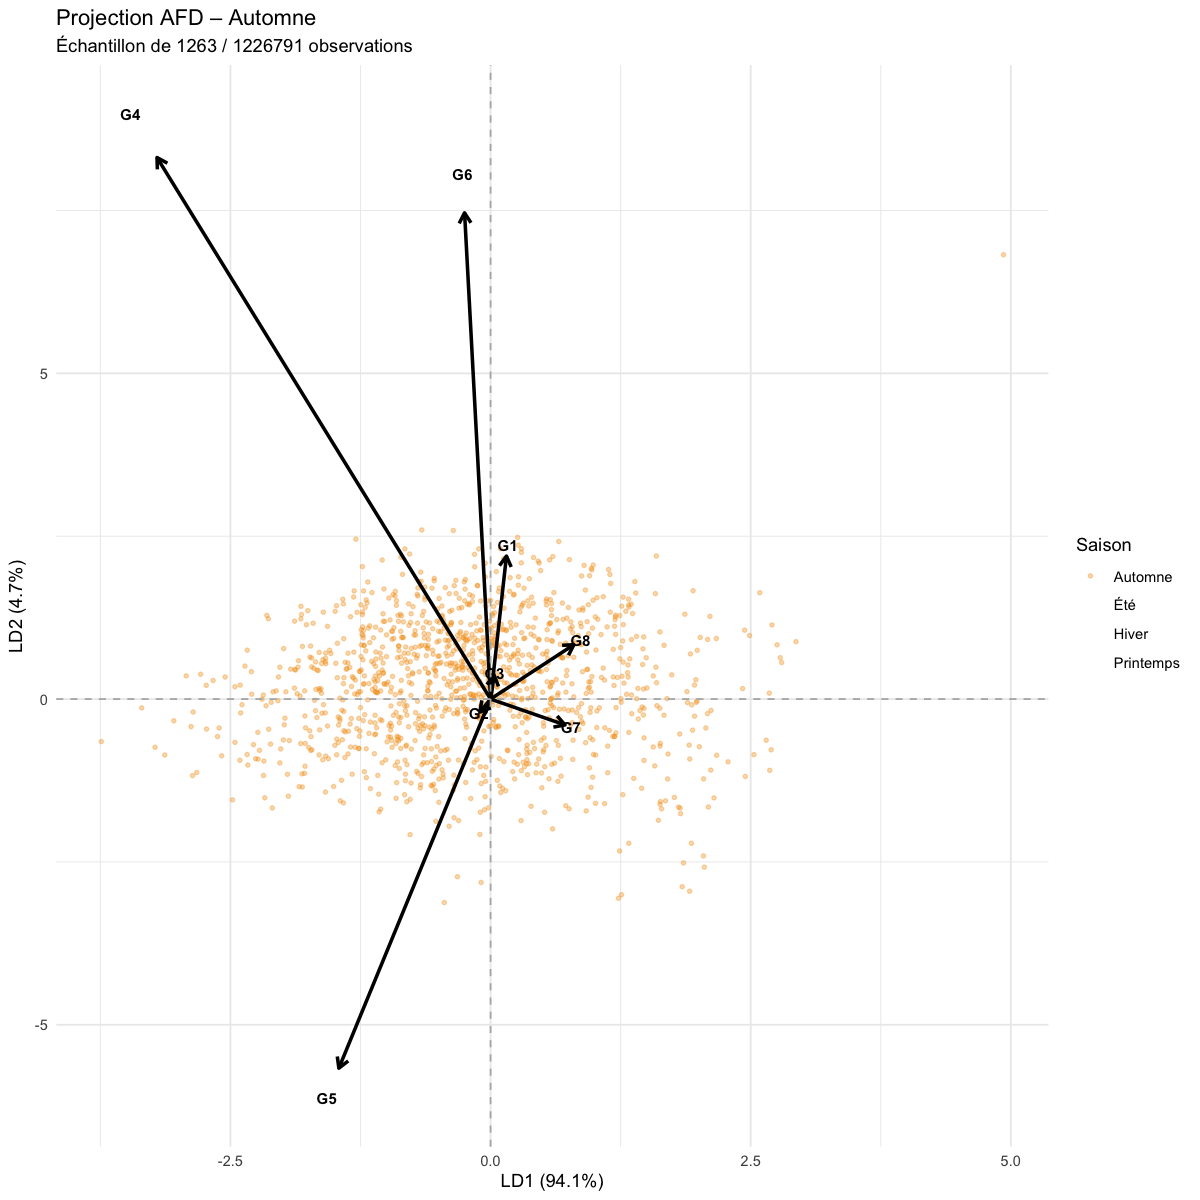

In [69]:
res_afd$plots$by_season$Hiver
res_afd$plots$by_season$Printemps
res_afd$plots$by_season$`Été`
res_afd$plots$by_season$Automne



Comme précédemment on observe que l'été et l'hiver se distingue facilement alors que la séparation entre le printemps et l'automne n'est pas très visible. Ceci peut s'expliquer par le fait que ce sont deux entre-saisons.

## Régression PLS

Pour cette partie, on va s'intéresser à une seule station en particulier. On isolera donc les observations de la station 7005 (Abbeville).

In [1]:
# Chargement du jeu de données
data <- read.csv("../data/station_7005_obs.csv", sep = ",") # Remplacer le lien par celui de votre jeu de données.

In [2]:
# Informations générales 
cat(strrep("-", 50), "\n")
cat("Dimension du dataset\n")
cat(strrep("-", 50), "\n")
dim_data <- dim(data)
cat("Nb d'observations :", dim_data[1], "\n")
cat("Nb de variables :", dim_data[2], "\n")

-------------------------------------------------- 
Dimension du dataset
-------------------------------------------------- 
Nb d'observations : 29191 
Nb de variables : 62 


In [3]:
# Liste des variables

cat(strrep("-", 50), "\n")
cat("Liste des variables :\n")
cat(strrep("-", 50), "\n")
print(names(data))

-------------------------------------------------- 
Liste des variables :
-------------------------------------------------- 
 [1] "ID.OMM.station"                                           
 [2] "Date"                                                     
 [3] "Pression.au.niveau.mer"                                   
 [4] "Variation.de.pression.en.3.heures"                        
 [5] "Type.de.tendance.barométrique"                            
 [6] "Direction.du.vent.moyen.10.mn"                            
 [7] "Vitesse.du.vent.moyen.10.mn"                              
 [8] "Température"                                              
 [9] "Point.de.rosée"                                           
[10] "Humidité"                                                 
[11] "Visibilité.horizontale"                                   
[12] "Temps.présent"                                            
[13] "Temps.passé.1"                                            
[14] "Temps.passé.2"         

In [4]:
# Summary of the dataset

cat(strrep("-", 50), "\n")
cat("Summary of the dataset\n")
cat(strrep("-", 50), "\n")
print(summary(data))

-------------------------------------------------- 
Summary of the dataset
-------------------------------------------------- 
 ID.OMM.station     Date           Pression.au.niveau.mer
 Min.   :7005   Length:29191       Min.   : 96820        
 1st Qu.:7005   Class :character   1st Qu.:101100        
 Median :7005   Mode  :character   Median :101740        
 Mean   :7005                      Mean   :101652        
 3rd Qu.:7005                      3rd Qu.:102310        
 Max.   :7005                      Max.   :104940        
                                   NA's   :12            
 Variation.de.pression.en.3.heures Type.de.tendance.barométrique
 Min.   :-1.140e+03                Min.   :0.000                
 1st Qu.:-7.000e+01                1st Qu.:2.000                
 Median : 0.000e+00                Median :4.000                
 Mean   :-3.051e-02                Mean   :4.335                
 3rd Qu.: 7.000e+01                3rd Qu.:7.000                
 Max.   : 1.030e+03

-------------------------------------------------- 
Analyse des données manquantes (en pourcentage)
-------------------------------------------------- 
                                           ID.OMM.station 
                                                    0.000 
                                                     Date 
                                                    0.000 
                                   Pression.au.niveau.mer 
                                                    0.041 
                        Variation.de.pression.en.3.heures 
                                                    0.055 
                            Type.de.tendance.barométrique 
                                                    0.055 
                            Direction.du.vent.moyen.10.mn 
                                                    0.130 
                              Vitesse.du.vent.moyen.10.mn 
                                                    0.130 
                      

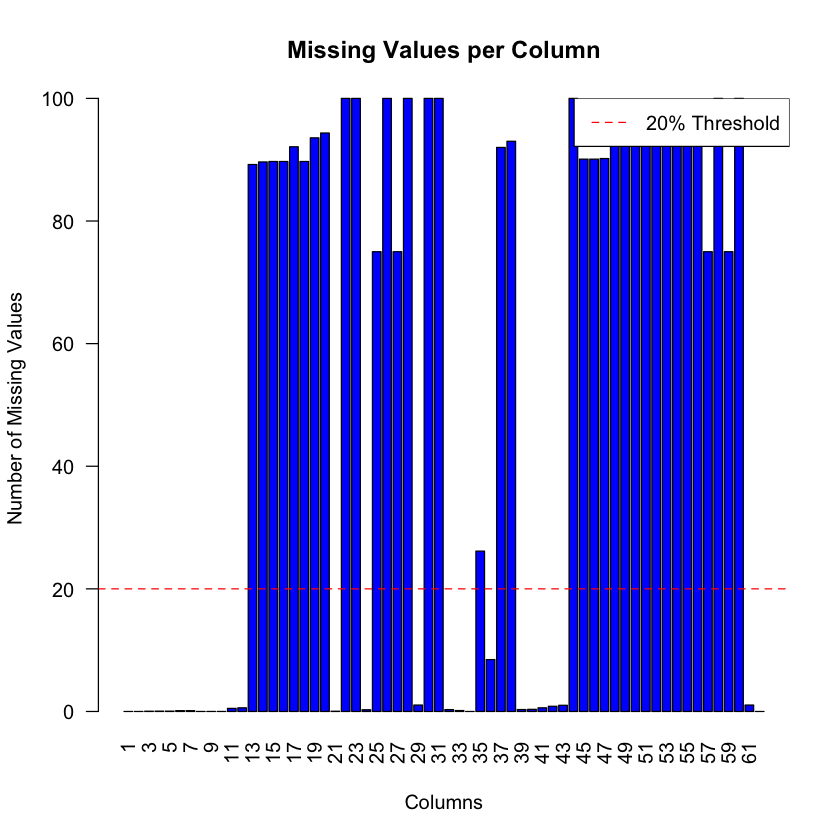

In [5]:
# Analyse des données manquantes (en pourcentage)
missing_values_percent <- colMeans(is.na(data)) * 100
cat(strrep("-", 50), "\n")
cat("Analyse des données manquantes (en pourcentage)\n")
cat(strrep("-", 50), "\n")
print(round(missing_values_percent, 3))

# Affichage dans un histogramme des valeurs manquantes par colonne
par(bg = "white")
barplot(missing_values_percent, main = "Missing Values per Column", 
        xlab = "Columns", ylab = "Number of Missing Values", col = "blue", las = 2,
        names.arg = seq_along(missing_values_percent))
# Rajouter une ligne horizontale pour indiquer un seuil de tolérance
abline(h = 20, col = "red", lty = 2)
legend("topright", legend = "20% Threshold", col = "red", lty = 2)


Afin d'avoir une meilleure visibilité sur le jeu de données et de réduire le nombre de variables sur lesquelles nous allons travaillé, nous avons d'abord écarté les variables non exploitables qui contiennent plus de 20 % de données manquantes.

In [6]:
# Suppression de colonnes avec plus de 20% de données manquantes
threshold_ratio <- 0.2
threshold <- threshold_ratio * nrow(data)
missing_values <- colSums(is.na(data))
columns_to_drop <- names(missing_values[missing_values > threshold])
data_cleaned <- data[, !(names(data) %in% columns_to_drop)]
cat(strrep("-", 50), "\n")
cat("Dimension du dataset après suppression des colonnes :\n")
cat(strrep("-", 50), "\n")
dim_data_cleaned <- dim(data_cleaned)
cat("Nb d'observations :", dim_data_cleaned[1], "\n")
cat("Nb de variables :", dim_data_cleaned[2], "\n")
cat(strrep("-", 50), "\n")
cat("Liste des variables après nettoyage :\n")
print(names(data_cleaned))

-------------------------------------------------- 
Dimension du dataset après suppression des colonnes :
-------------------------------------------------- 
Nb d'observations : 29191 
Nb de variables : 26 
-------------------------------------------------- 
Liste des variables après nettoyage :
 [1] "ID.OMM.station"                                           
 [2] "Date"                                                     
 [3] "Pression.au.niveau.mer"                                   
 [4] "Variation.de.pression.en.3.heures"                        
 [5] "Type.de.tendance.barométrique"                            
 [6] "Direction.du.vent.moyen.10.mn"                            
 [7] "Vitesse.du.vent.moyen.10.mn"                              
 [8] "Température"                                              
 [9] "Point.de.rosée"                                           
[10] "Humidité"                                                 
[11] "Visibilité.horizontale"                        

In [7]:
# Récupération des variables numériques
# On considère les variables date, ID.OMM.station, mois de l'année comme catégorielle.
categorical_var = c("Date", "ID.OMM.station", "mois_de_l_annee")
data_numeric <- data_cleaned[, !(names(data_cleaned) %in% categorical_var)]

cat(strrep("-", 50), "\n")
cat("Variables numériques :\n")
cat(strrep("-", 50), "\n")
cat("Nb de variables :", length(names(data_numeric)), "\n")
print(names(data_numeric))
cat(strrep("-", 50), "\n")


-------------------------------------------------- 
Variables numériques :
-------------------------------------------------- 


Nb de variables : 23 
 [1] "Pression.au.niveau.mer"                                   
 [2] "Variation.de.pression.en.3.heures"                        
 [3] "Type.de.tendance.barométrique"                            
 [4] "Direction.du.vent.moyen.10.mn"                            
 [5] "Vitesse.du.vent.moyen.10.mn"                              
 [6] "Température"                                              
 [7] "Point.de.rosée"                                           
 [8] "Humidité"                                                 
 [9] "Visibilité.horizontale"                                   
[10] "Temps.présent"                                            
[11] "Pression.station"                                         
[12] "Variation.de.pression.en.24.heures"                       
[13] "Température.minimale.du.sol.sur.12.heures"                
[14] "Rafale.sur.les.10.dernières.minutes"                      
[15] "Rafales.sur.une.période"                                  
[16

On réalise une analyse de corrélation entre les variables pour pouvoir écarter les variables redondantes de notre modèle.

In [8]:
library(corrplot)

corrplot 0.95 loaded



Indices et noms des colonnes :


1 : Pression.au.niveau.mer 
2 : Variation.de.pression.en.3.heures 
3 : Type.de.tendance.barométrique 
4 : Direction.du.vent.moyen.10.mn 
5 : Vitesse.du.vent.moyen.10.mn 
6 : Température 
7 : Point.de.rosée 
8 : Humidité 
9 : Visibilité.horizontale 
10 : Temps.présent 
11 : Pression.station 
12 : Variation.de.pression.en.24.heures 
13 : Température.minimale.du.sol.sur.12.heures 
14 : Rafale.sur.les.10.dernières.minutes 
15 : Rafales.sur.une.période 
16 : Periode.de.mesure.de.la.rafale 
17 : Hauteur.totale.de.la.couche.de.neige..glace..autre.au.sol 
18 : Précipitations.dans.la.dernière.heure 
19 : Précipitations.dans.les.3.dernières.heures 
20 : Précipitations.dans.les.6.dernières.heures 
21 : Précipitations.dans.les.12.dernières.heures 
22 : Précipitations.dans.les.24.dernières.heures 
23 : Température.minimale.du.sol.sur.12.heures..en..C. 


Warning message in cor(data_numeric, use = "pairwise.complete.obs"):
“l'écart type est nul”


-------------------------------------------------- 
10 paires de variables les plus corrélées :
-------------------------------------------------- 
1. Température.minimale.du.sol.sur.12.heures et Température.minimale.du.sol.sur.12.heures..en..C. : 1
2. Pression.au.niveau.mer et Pression.station : 1
3. Rafale.sur.les.10.dernières.minutes et Rafales.sur.une.période : 0.962
4. Vitesse.du.vent.moyen.10.mn et Rafale.sur.les.10.dernières.minutes : 0.936
5. Vitesse.du.vent.moyen.10.mn et Rafales.sur.une.période : 0.899
6. Point.de.rosée et Température.minimale.du.sol.sur.12.heures..en..C. : 0.891
7. Point.de.rosée et Température.minimale.du.sol.sur.12.heures : 0.891
8. Température et Point.de.rosée : 0.843
9. Température et Température.minimale.du.sol.sur.12.heures : 0.829
10. Température et Température.minimale.du.sol.sur.12.heures..en..C. : 0.829
-------------------------------------------------- 


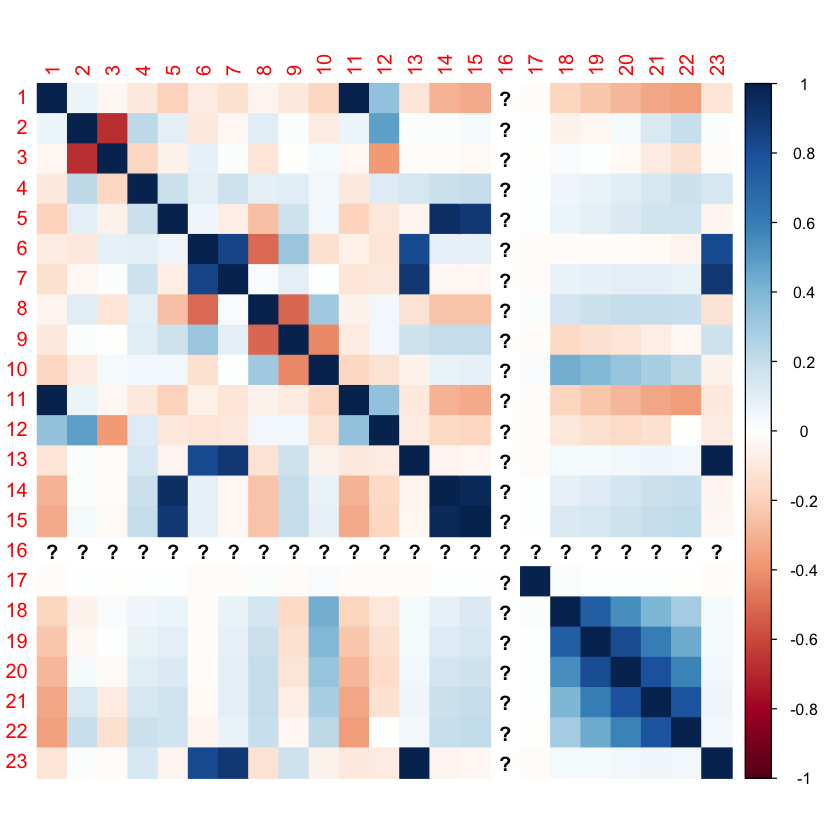

In [9]:
# Affichage graphique de la matrice de corrélation
# Afficher les indices et les noms des colonnes
cat("Indices et noms des colonnes :\n")
for (i in seq_along(names(data_numeric))) {
    cat(i, ":", names(data_numeric)[i], "\n")
}
# Remplacer les noms des colonnes par leurs indices dans la matrice de corrélation

par(bg = "white")

cor_matrix <- cor(data_numeric, use = "pairwise.complete.obs")
colnames(cor_matrix) <- rownames(cor_matrix) <- seq_len(ncol(cor_matrix))
corrplot(cor_matrix, method = "color")

# Print les 5 paires de variables les plus corrélées
cor_matrix[lower.tri(cor_matrix, diag = TRUE)] <- NA
cor_values <- as.data.frame(as.table(cor_matrix))
cor_values <- na.omit(cor_values)
cor_values <- cor_values[order(-abs(cor_values$Freq)), ]
cat(strrep("-", 50), "\n")
cat("10 paires de variables les plus corrélées :\n")
cat(strrep("-", 50), "\n")
for (i in 1:10) {
    var1_index <- cor_values[i, 1]
    var2_index <- cor_values[i, 2]
    var1_name <- names(data_numeric)[as.numeric(var1_index)]
    var2_name <- names(data_numeric)[as.numeric(var2_index)]
    cat(paste0(i, ". ", var1_name, " et ", var2_name, " : ", round(cor_values[i, 3], 3), "\n"))
}
cat(strrep("-", 50), "\n")

Suite à cette étude de corrélation, on supprimera les colonnes suivantes : 
- Température.minimale.du.sol.sur.12.heures..en..C. (redondante avec la même variable en Kelvin)
- Pression.au.niveau.mer (redondante avec la pression station)
- Rafales.sur.une.période (redondante avec Rafales sur les 10 dernières minutes)
- Periode.de.mesure.de.la.rafale

La variable Hauteur.totale.de.la.couche.de.neige..glace..autre.au.sol étant constante à 0, on la retire également.

In [10]:
# Suppression des variables redondantes et inutiles - Température.minimale.du.sol.sur.12.heures..en..C. - Pression.au.niveau.mer - Rafales.sur.une.période - Periode.de.mesure.de.la.rafale

data_final <- data_numeric[, !(names(data_numeric) %in% c("Température.minimale.du.sol.sur.12.heures..en..C.", 
                                                              "Pression.au.niveau.mer", 
                                                              "Rafales.sur.une.période", 
                                                              "Periode.de.mesure.de.la.rafale",
                                                              "Hauteur.totale.de.la.couche.de.neige..glace..autre.au.sol"))]

In [12]:
length(names(data_final))

[1] 18

On réalise une régression PLS pour prédire la variable cible "Température" en utilisant les autres variables numériques restantes.

In [15]:
library(pls)

Data: 	X dimension: 28390 17 
	Y dimension: 28390 1
Fit method: kernelpls
Number of components considered: 17

VALIDATION: RMSEP
Cross-validated using 10 random segments.
       (Intercept)  1 comps  2 comps  3 comps  4 comps  5 comps  6 comps
CV           6.316    5.986    5.943    5.928    5.823    4.656     3.17
adjCV        6.316    5.986    5.943    5.928    5.823    4.672     3.17
       7 comps  8 comps  9 comps  10 comps  11 comps  12 comps  13 comps
CV       1.553    1.302   0.7702    0.6014    0.5818    0.5807    0.5807
adjCV    1.553    1.302   0.7700    0.6014    0.5818    0.5807    0.5806
       14 comps  15 comps  16 comps  17 comps
CV       0.5806    0.5805    0.5805    0.5805
adjCV    0.5806    0.5805    0.5805    0.5805

TRAINING: % variance explained
   1 comps  2 comps  3 comps  4 comps  5 comps  6 comps  7 comps  8 comps
X    97.02    98.78    99.96    99.97    99.99   100.00   100.00   100.00
y    10.18    11.47    11.91    15.02    45.28    74.82    93.96    95.75

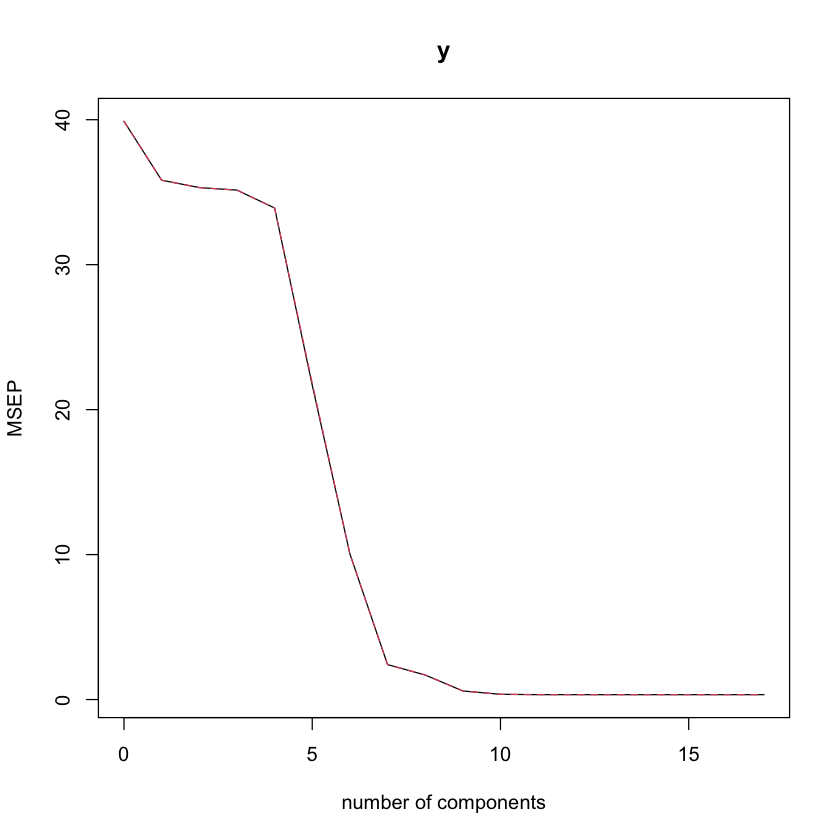

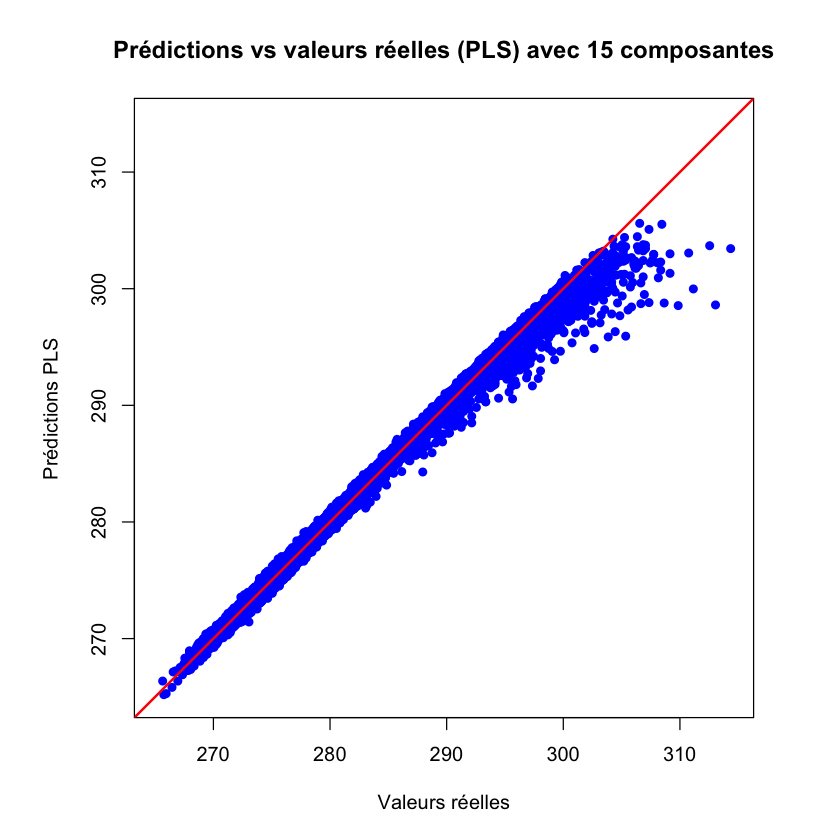

In [19]:
# Utiliser le nom exact de la variable cible
target_var <- "Température"


# Créer un data.frame avec toutes les variables nécessaires
df_pls <- data_final[, c(target_var, setdiff(names(data_final), target_var))]
df_pls <- na.omit(df_pls) # Retirer toutes les lignes avec NA

y <- df_pls[[target_var]]
X <- df_pls[, setdiff(names(df_pls), target_var), drop = FALSE]

# Régression PLS avec validation croisée
pls_model <- plsr(y ~ as.matrix(X), validation = "CV")

# Résumé du modèle
summary(pls_model)

# Sélection du nombre optimal de composantes
par(bg = 'white')
validationplot(pls_model, val.type = "MSEP")

# Trouver le nombre optimal de composantes
opt_ncomp <- which.min(pls_model$validation$PRESS)

cat("Nombre optimal de composantes :", opt_ncomp, "\n")
# Prédictions
pred <- predict(pls_model, ncomp = opt_ncomp)
pred_vec <- as.vector(pred[,1,1])

# Plot prédiction vs ground truth
par(pty = "s")
plot_lim <- range(c(y, pred_vec))
plot(y, pred_vec, 
     xlab = "Valeurs réelles", 
     ylab = "Prédictions PLS", 
     main = paste("Prédictions vs valeurs réelles (PLS) avec", opt_ncomp, "composantes"), 
     col = "blue", pch = 16,
     xlim = plot_lim, ylim = plot_lim)

abline(a = 0, b = 1, col = "red", lwd = 2)


#### Performance du modèle (mesurée avec la RMSEP)


- Baseline (Intercept) : RMSEP = 6.316°C

- Amélioration progressive jusqu'à 7 composantes :

    - 1-4 composantes : amélioration modeste (6.316 → 5.823)
    - 5-6 composantes : amélioration notable (5.823 → 3.171)
    - 7 composantes : saut majeur (3.171 → 1.553)
    - 8-9 composantes : encore une amélioration (1.553 → 0.771)
- Plateau optimal : À partir de 12 composantes

    RMSEP minimal ≈ 0.58°C 


#### Variance expliquée
- Variables prédictives (X) :

    97% dès la 1ère composante
    100% atteint à partir de la 6ème composante
- Variable cible (Y - Température) :

    Progression avec deux phases :
    - Phase 1 (1-4 comp.) : lente (10% → 15%)
    - Phase 2 (5-7 comp.) : explosive (15% → 45% → 75% → 94%)
    - Phase 3 (8+ comp.) : stabilisation à 99.16%

#### Qualité du modèle :

RMSEP de 0.58°C pour prédire la température
Modèle plutôt précis.
Points d'attention : potentiel dataleakage, variables redondantes ou variables donnant directement accès à la cible (point de rosée/température minimal du sol).


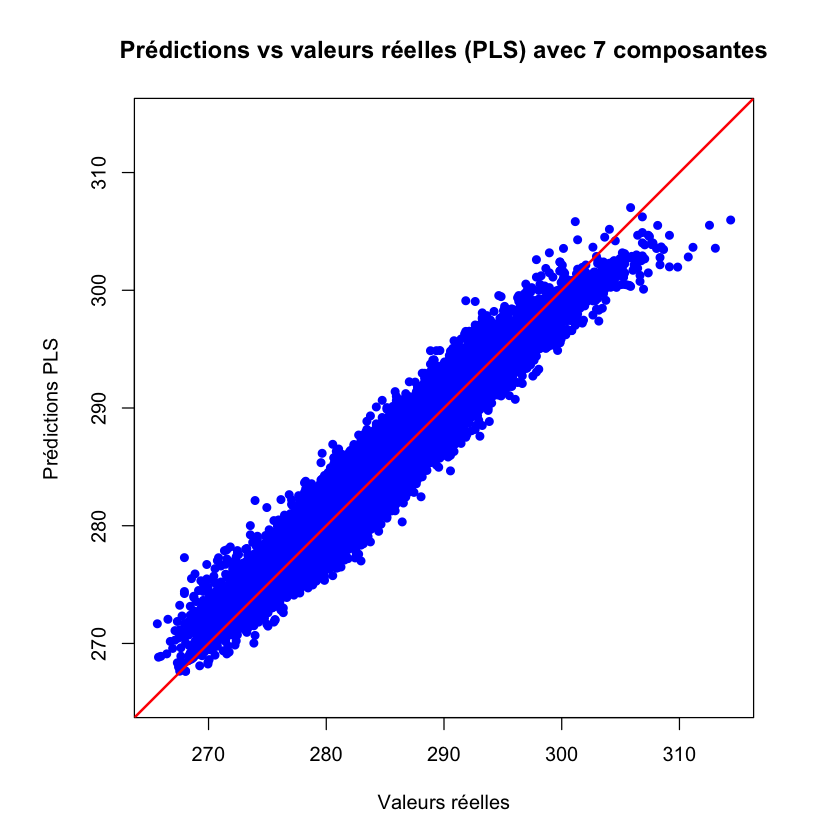

In [23]:
# Régression PLS avec 7 composantes

# Régression PLS avec validation croisée
pls_model <- plsr(y ~ as.matrix(X), validation = "CV")

# Prédictions
pred <- predict(pls_model, ncomp = 7)
pred_vec <- as.vector(pred[,1,1])

# Plot prédiction vs ground truth
par(pty = "s", bg = "white")
plot_lim <- range(c(y, pred_vec))
plot(y, pred_vec, 
     xlab = "Valeurs réelles", 
     ylab = "Prédictions PLS", 
     main = paste("Prédictions vs valeurs réelles (PLS) avec", 7, "composantes"), 
     col = "blue", pch = 16,
     xlim = plot_lim, ylim = plot_lim)

abline(a = 0, b = 1, col = "red", lwd = 2)


# Clustering

### Comparaison de données : climat pluvieux vs climat sec

Dans cette partie, nous nous proposons de comparer deux stations situées dans des endroits au climat très différent : la station de Guipavas, près de Brest, en Bretagne, et la station de Perpignan, dans le sud de la France. Nous partons du postulat que la station brestoise a un climat pluvieux et nous souhaitons effectuer une présentation croisée des données respectives des deux stations.

In [20]:
# Chargement des données nettoyées pour les deux stations
data_cleaned_7747 <- read.csv("/home/jmaubian/SDD/Projet_stat_meteo/stations_csv/station_7747.csv", header = TRUE, sep=",", dec=".")
data_cleaned_7110 <- read.csv("/home/jmaubian/SDD/Projet_stat_meteo/stations_csv/station_7110.csv", header = TRUE, sep=",", dec=".")

Nous voulons dans un premier temps comparer simplement les températures mmédianes par saison afin de vérifier notre intuiton première : il fait statistiquement plus chaud dans le sud qu'en Bretagne. Pour cela, nous traçons simplement les *boxplots* des températures par saison de chacune des stations.

Warning message:
“Removed 21 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 94 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


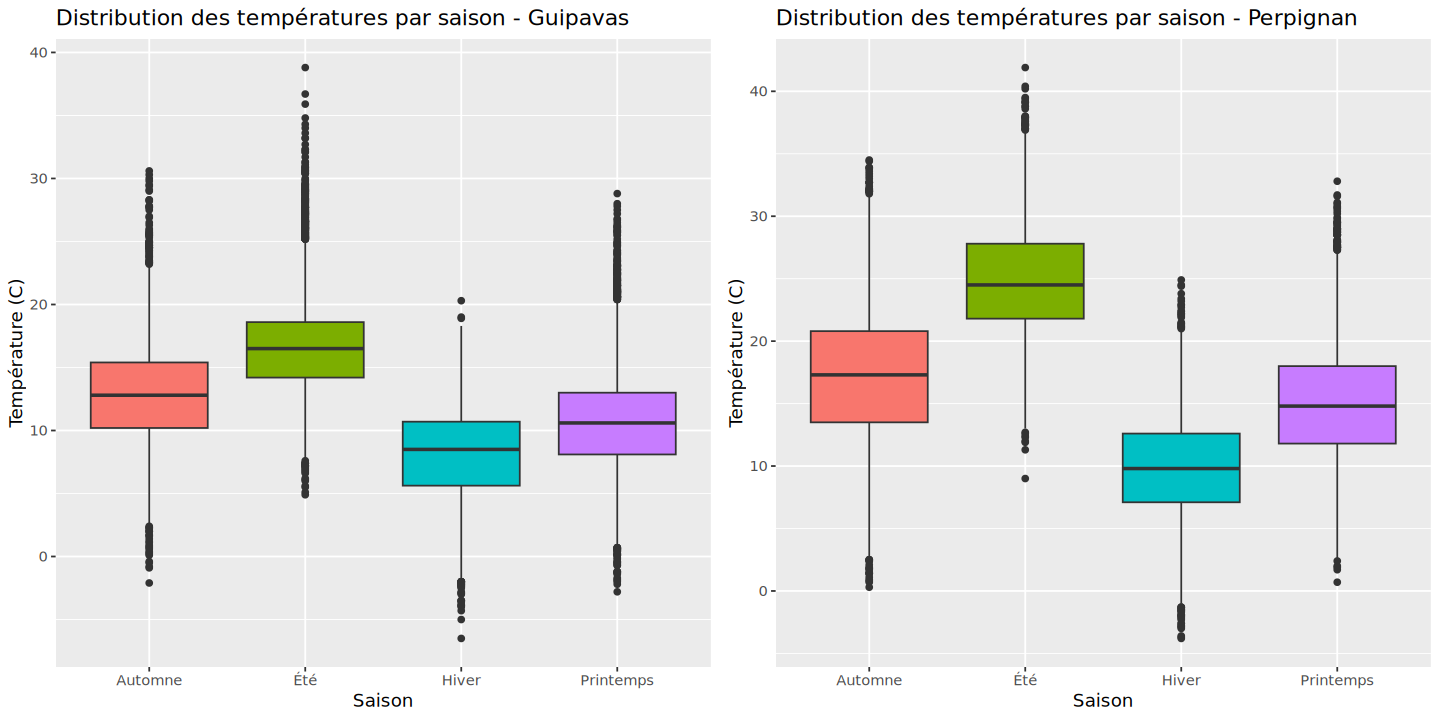

In [21]:
# Packages nécessaires
library(lubridate)
library(ggplot2)
library(gridExtra)

### Guipavas
options(repr.plot.width=12, repr.plot.height=6)

# Regrouper par mois ou saisons
data_cleaned_7110$Date <- as.POSIXct(data_cleaned_7110$Date, format="%Y-%m-%dT%H:%M:%S", tz="Europe/Berlin")
data_cleaned_7110$mois <- month(data_cleaned_7110$Date)
data_cleaned_7110$saison <- ifelse(data_cleaned_7110$mois %in% c(12, 1, 2), "Hiver",
                            ifelse(data_cleaned_7110$mois %in% c(3, 4, 5), "Printemps",
                                   ifelse(data_cleaned_7110$mois %in% c(6, 7, 8), "Été", "Automne")))

# Boxplot Température par saison
p1 <- ggplot(data_cleaned_7110, aes(x=saison, y=Température-273.15, fill=saison)) + geom_boxplot() +
ggtitle("Distribution des températures par saison - Guipavas") +
xlab("Saison") + ylab("Température (C)") +
theme(legend.position="none")

### Perpignan
# Regrouper par mois ou saisons
data_cleaned_7747$Date <- as.POSIXct(data_cleaned_7747$Date, format="%Y-%m-%dT%H:%M:%S", tz="Europe/Berlin")
data_cleaned_7747$mois <- month(data_cleaned_7747$Date)
data_cleaned_7747$saison <- ifelse(data_cleaned_7747$mois %in% c(12, 1, 2), "Hiver",
                            ifelse(data_cleaned_7747$mois %in% c(3, 4, 5), "Printemps",
                                   ifelse(data_cleaned_7747$mois %in% c(6, 7, 8), "Été", "Automne")))

# Boxplot Température par saison
p2 <- ggplot(data_cleaned_7747, aes(x=saison, y=Température-273.15, fill=saison)) + geom_boxplot() +
ggtitle("Distribution des températures par saison - Perpignan") +
xlab("Saison") + ylab("Température (C)") +
theme(legend.position="none")

grid.arrange(p1,p2,ncol=2)

Warning message:
“Removed 21 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 94 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


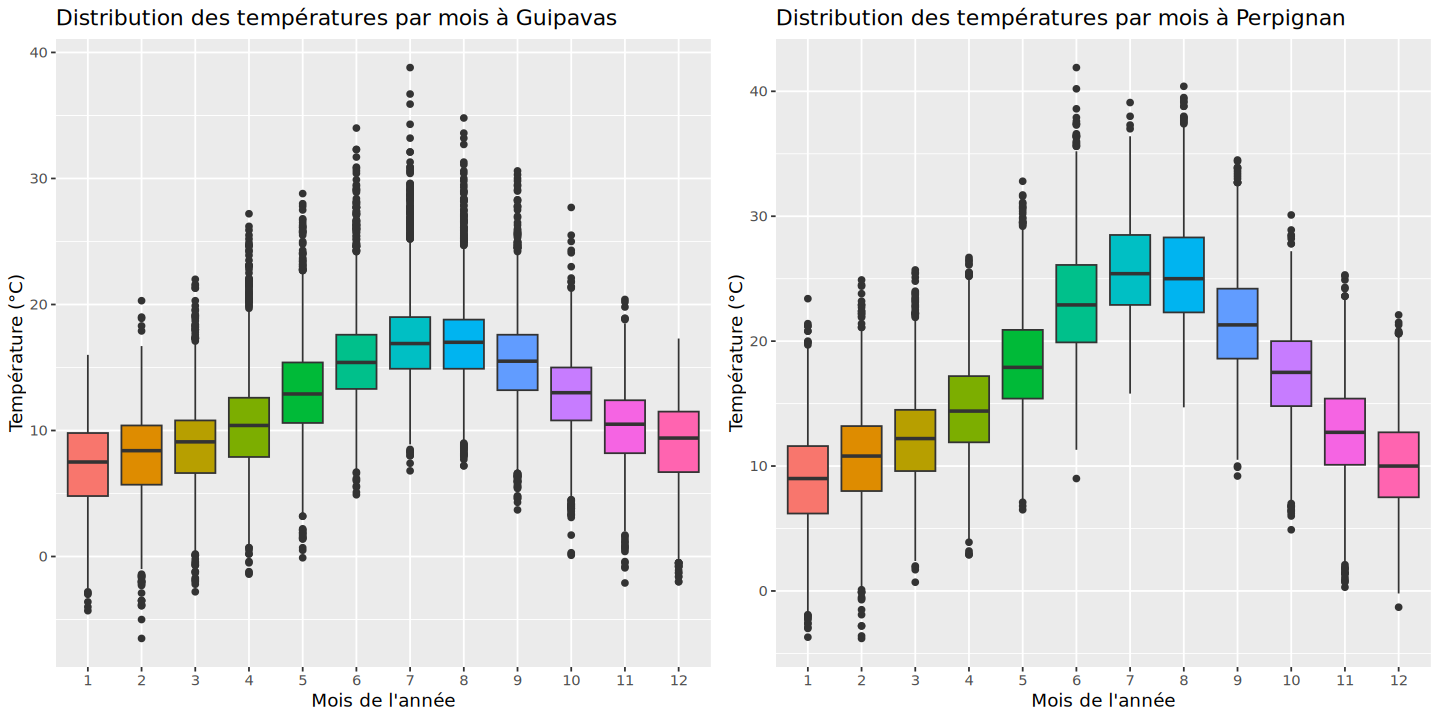

In [22]:
library(gridExtra)

options(repr.plot.width=12, repr.plot.height=6)

p1 <- ggplot(data_cleaned_7110, aes(x = factor(mois), y = Température -273.15, fill = factor(mois))) +
  geom_boxplot() +
  ggtitle("Distribution des températures par mois à Guipavas") +
  xlab("Mois de l'année") + ylab("Température (°C)") +
  theme(legend.position="none")

p2 <- ggplot(data_cleaned_7747, aes(x = factor(mois), y = Température -273.15, fill = factor(mois))) +
  geom_boxplot() +
  ggtitle("Distribution des températures par mois à Perpignan") +
  xlab("Mois de l'année") + ylab("Température (°C)") +
  theme(legend.position="none")

# Affichage côte à côte
grid.arrange(p1, p2, ncol = 2)


La distribution des températures nous confirme qu'il fait en moyenne plus chaud à Perpignan. Les variations de température sont cepedant plus importantes à Perpignan, notamment en automne.

La question que nous nous posons ensuite est celle de l'humidité : nous partons du principe qu'avec le climat océanique, il fait plus humide à Guipavas. Nous traçons alors de la même façon les *boxplot* en fonction des saisons.

Warning message:
“Removed 37 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 78 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


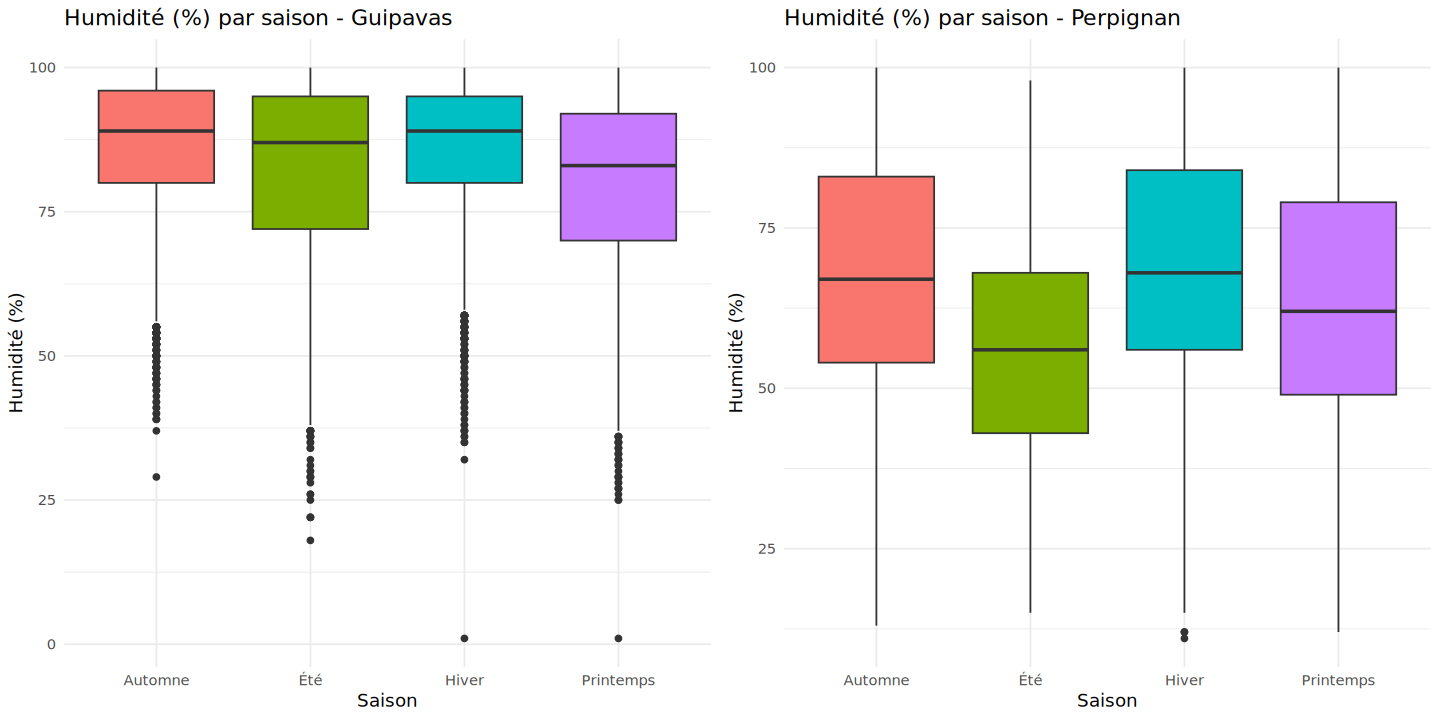

In [23]:
library(gridExtra)
options(repr.plot.width=12, repr.plot.height=6)

# Humidité par saison
p1<-ggplot(data_cleaned_7110, aes(x=saison, y=Humidité, fill=saison)) +
  geom_boxplot() +
  ggtitle("Humidité (%) par saison - Guipavas") + xlab("Saison") + ylab("Humidité (%)") +
  theme_minimal() +
  theme(legend.position="none")

# Humidité par saison
p2<-ggplot(data_cleaned_7747, aes(x=saison, y=Humidité, fill=saison)) +
  geom_boxplot() +
  ggtitle("Humidité (%) par saison - Perpignan") + xlab("Saison") + ylab("Humidité (%)") +
  theme_minimal() +
  theme(legend.position="none")

grid.arrange(p1,p2,ncol=2)


La médiane de l'humidité reste globalement la même à Guipavas, avec des niveaux d'humidité élevés au long de l'année. Au contraire, au fil des saisons, l'humidité varie à Perpignan, restant tout au long de l'année en moyenne inférieure à celle relevée à Guipavas.

Se pose alors la question des précipitations : en effet, il est connu qu'il pleut beaucoup en Bretagne, et notamment dans le nord Finistère. Nous souhaitons alors vérifier cette affirmation par rapport à Perpignan, ville où il pleut le moins. 

Warning message:
“Removed 856 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 864 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


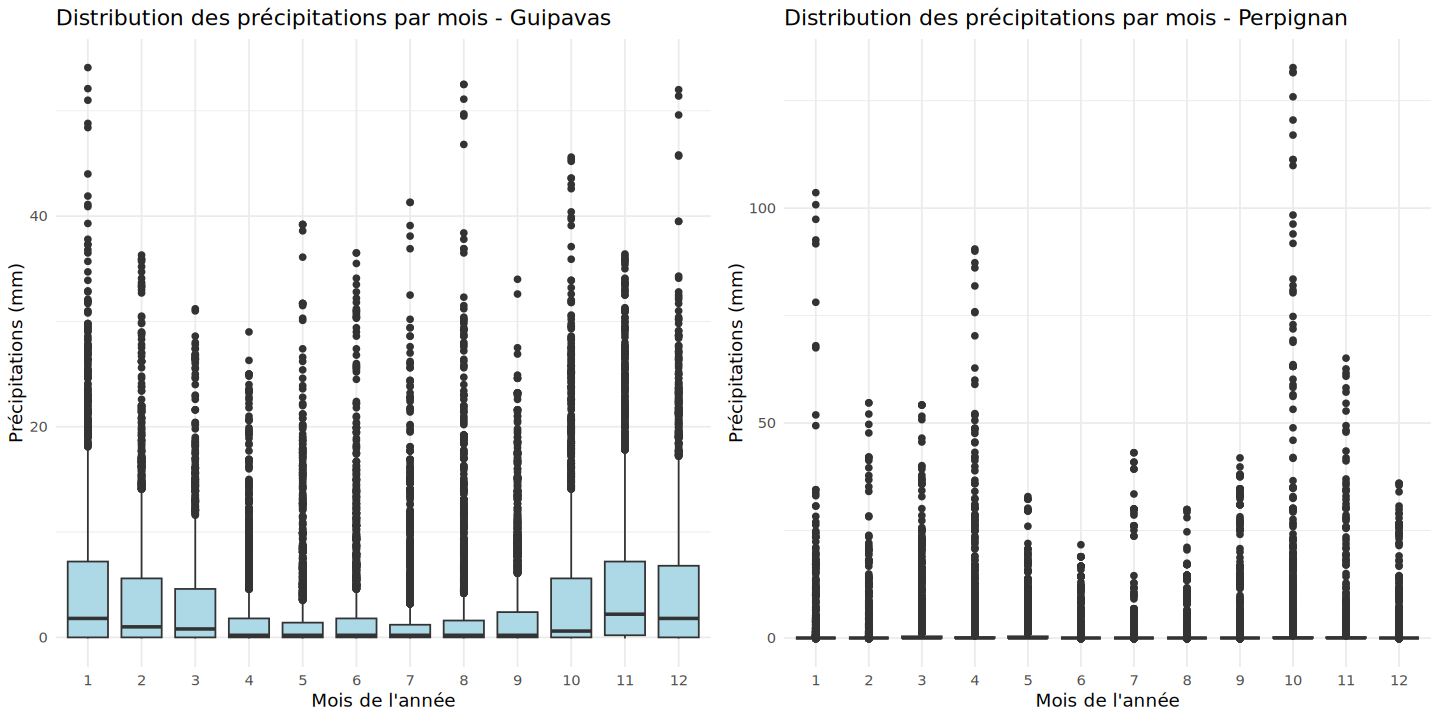

In [24]:
library(ggplot2)
library(gridExtra)

options(repr.plot.width=12, repr.plot.height=6)

p1 <- ggplot(data_cleaned_7110, aes(x = factor(mois), y = Précipitations.dans.les.24.dernières.heures)) +
  geom_boxplot(fill="lightblue") +
  xlab("Mois de l'année") +
  ylab("Précipitations (mm)") +
  ggtitle("Distribution des précipitations par mois - Guipavas") +
  theme_minimal()


p2 <- ggplot(data_cleaned_7747, aes(x = factor(mois), y = Précipitations.dans.les.24.dernières.heures)) +
  geom_boxplot(fill="lightblue") +
  xlab("Mois de l'année") +
  ylab("Précipitations (mm)") +
  ggtitle("Distribution des précipitations par mois - Perpignan") +
  theme_minimal()

grid.arrange(p1, p2, ncol = 2)


Ces *boxplot* des précipitations confirment qu'il pleut en moyenne bien plus à Guipavas qu'à Perpignan, avec des variations selon les mois pour Guipavas. Il pleut effectivement en moyenne plus en automne et en hiver que durant le reste de l'année.

Warning message:
“Removed 856 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 864 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


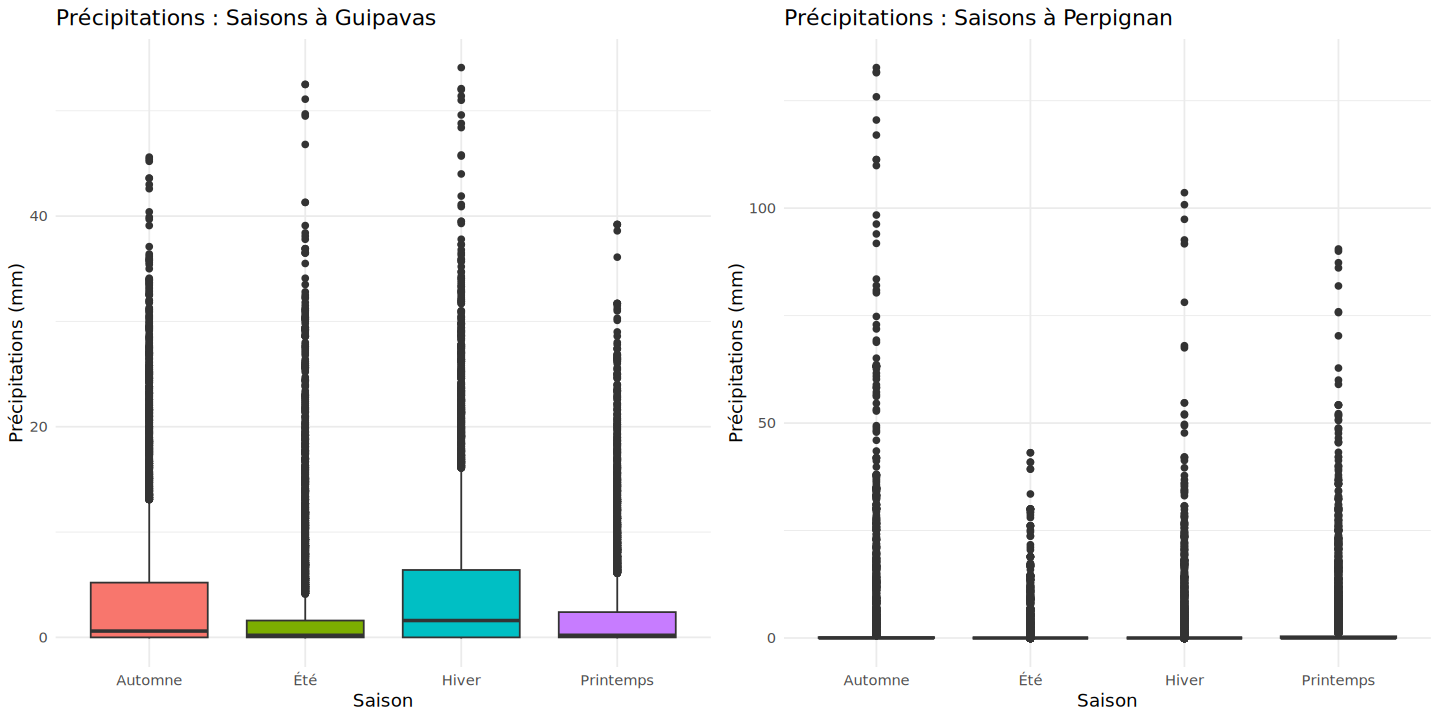

In [25]:
precip_saison_guip <- subset(data_cleaned_7110, saison %in% c("Hiver", "Printemps", "Été", "Automne"))
precip_saison_perp <- subset(data_cleaned_7747, saison %in% c("Hiver", "Printemps", "Été", "Automne"))


library(ggplot2)
library(gridExtra)

options(repr.plot.width=12, repr.plot.height=6)

p1 <- ggplot(precip_saison_guip, aes(x = saison, y = Précipitations.dans.les.24.dernières.heures, fill=saison)) +
  geom_boxplot() +
  ylab("Précipitations (mm)") +
  xlab("Saison") +
  ggtitle("Précipitations : Saisons à Guipavas") +
  theme_minimal() +
  theme(legend.position="none")


p2 <- ggplot(precip_saison_perp, aes(x = saison, y = Précipitations.dans.les.24.dernières.heures, fill=saison)) +
  geom_boxplot() +
  ylab("Précipitations (mm)") +
  xlab("Saison") +
  ggtitle("Précipitations : Saisons à Perpignan") +
  theme_minimal() +
  theme(legend.position="none")

grid.arrange(p1, p2, ncol = 2)


# Clustering climat

In [ ]:
library(dplyr)
library(lubridate)
library(ggplot2)
library(maps)
library(ggrepel)
library(dendextend)

library(ggplot2)
library(maps)
library(FNN)
library(sp)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



---------------------
Welcome to dendextend version 1.19.1
Type citation('dendextend') for how to cite the package.

Type browseVignettes(package = 'dendextend') for the package vignette.
The github page is: https://github.com/talgalili/dendextend/

Suggestions and bug-reports can be submitted at: https://github.com/talgalili/dendextend/issues
You may ask questions at stackoverflow, use the r and dendextend tags: 
	 https://stackoverflow.com/questions/tagged/dendextend

	To suppress this message use:  suppressPackageStartupMessages(library(dendextend))
---------------------



Attaching package: ‘dendextend’


The following object is masked from ‘package:stats’:


L'objectif de cette section est d'essayer de retrouver les différents types de climats en France métropolitaine, à partir de notre jeu de données. Pour cela, nous effectuons un clustering sur les différentes stations, en des moyennes et écarts-types de différentes grandeurs (température, humidité, vent, précipitations, nébulosité).

Dans un premier temps, nous sélectionnons tout ça et mettons tout dans 'stations_france'.

In [13]:
stations_climat <- observations %>%
  group_by(ID.OMM.station, Latitude, Longitude, Altitude) %>%
  summarise(temp_moy = mean(Température, na.rm=TRUE),
            temp_sd = sd(Température, na.rm=TRUE),
            temp_ete = mean(Température[month(Date) %in% c(6,7,8)], na.rm=TRUE),
            temp_hiver = mean(Température[month(Date) %in% c(12,1,2)], na.rm=TRUE),
            hum_moy = mean(Humidité, na.rm=TRUE),
            hum_sd = sd(Humidité, na.rm=TRUE),
            vent_moy = mean(Vitesse.du.vent.moyen.10.mn, na.rm=TRUE),
            vent_sd = sd(Vitesse.du.vent.moyen.10.mn, na.rm=TRUE),
            precip_moy = mean(Précipitations.dans.les.24.dernières.heures, na.rm=TRUE),
            precip_sd = sd(Précipitations.dans.les.24.dernières.heures, na.rm=TRUE),
            nebul_moy = mean(Nebulosité.totale, na.rm=TRUE),
            .groups = "drop")

stations_climat <- stations_climat %>%
  left_join(stations %>% 
              select(ID.OMM.station, communes..name., department..name., region..name.),
            by = "ID.OMM.station")

stations_france <- stations_climat %>%
  filter(Latitude >= 42, Latitude <= 51,
         Longitude >= -5, Longitude <= 10)

head(stations_france)

ID.OMM.station Latitude Longitude Altitude temp_moy temp_sd  temp_ete
1 7005           50.13600  1.834000  69      284.7995 6.329857 291.1003
2 7015           50.57000  3.097500  47      285.1373 6.913029 292.2792
3 7020           49.72517 -1.939833   6      285.9265 4.035360 289.8773
4 7027           49.18000 -0.456167  67      285.0625 6.023839 290.9454
5 7037           49.38300  1.181667 151      284.6429 6.682290 291.3540
6 7072           49.20967  4.155333  95      284.8362 7.563019 292.4289
  temp_hiver hum_moy  hum_sd   vent_moy vent_sd  precip_moy precip_sd nebul_moy
1 278.8929   80.33446 15.00129 3.600912 2.252659 2.194954   4.575288  72.55759 
2 278.5218   77.25565 17.06096 4.178517 2.452241 1.924008   4.172185  96.49914 
3 282.0276   81.67951 10.40275 6.758472 3.573506 2.088533   4.540331  69.14118 
4 279.6901   81.25286 13.97170 4.246815 2.474953 1.898839   4.056612  94.13673 
5 278.4196   79.98217 16.44134 4.039976 2.133913 2.130887   4.228155  94.67241 
6 278.0861   78.50429 16.95049 3.138859 2.026884 1.598263   3.893918  97.29704 
  communes..name. department..name. region..name.  
1 Abbeville       Somme             Hauts-de-France
2 Fretin          Nord              Hauts-de-France
3 La Hague        Manche            Normandie      
4 Carpiquet       Calvados          Normandie      
5 Boos            Seine-Maritime    Normandie      
6 Prunay          Marne             Grand Est

On centre et réduit les grandeurs utilisées pour le clustering

In [14]:
data_scaled <- scale(stations_france %>% 
                         select(temp_moy, temp_sd, temp_ete, temp_hiver, hum_moy, hum_sd, vent_moy, vent_sd, precip_moy, precip_sd)
                    )
rownames(data_scaled) <- stations_france$communes..name.

On élabore maintenant un dendrogramme

Warning message in plot.window(...):
“"hang" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"hang" is not a graphical parameter”
Warning message in axis(side = side, at = at, labels = labels, ...):
“"hang" is not a graphical parameter”
Warning message in axis(side = side, at = at, labels = labels, ...):
“"hang" is not a graphical parameter”
Warning message in title(...):
“"hang" is not a graphical parameter”


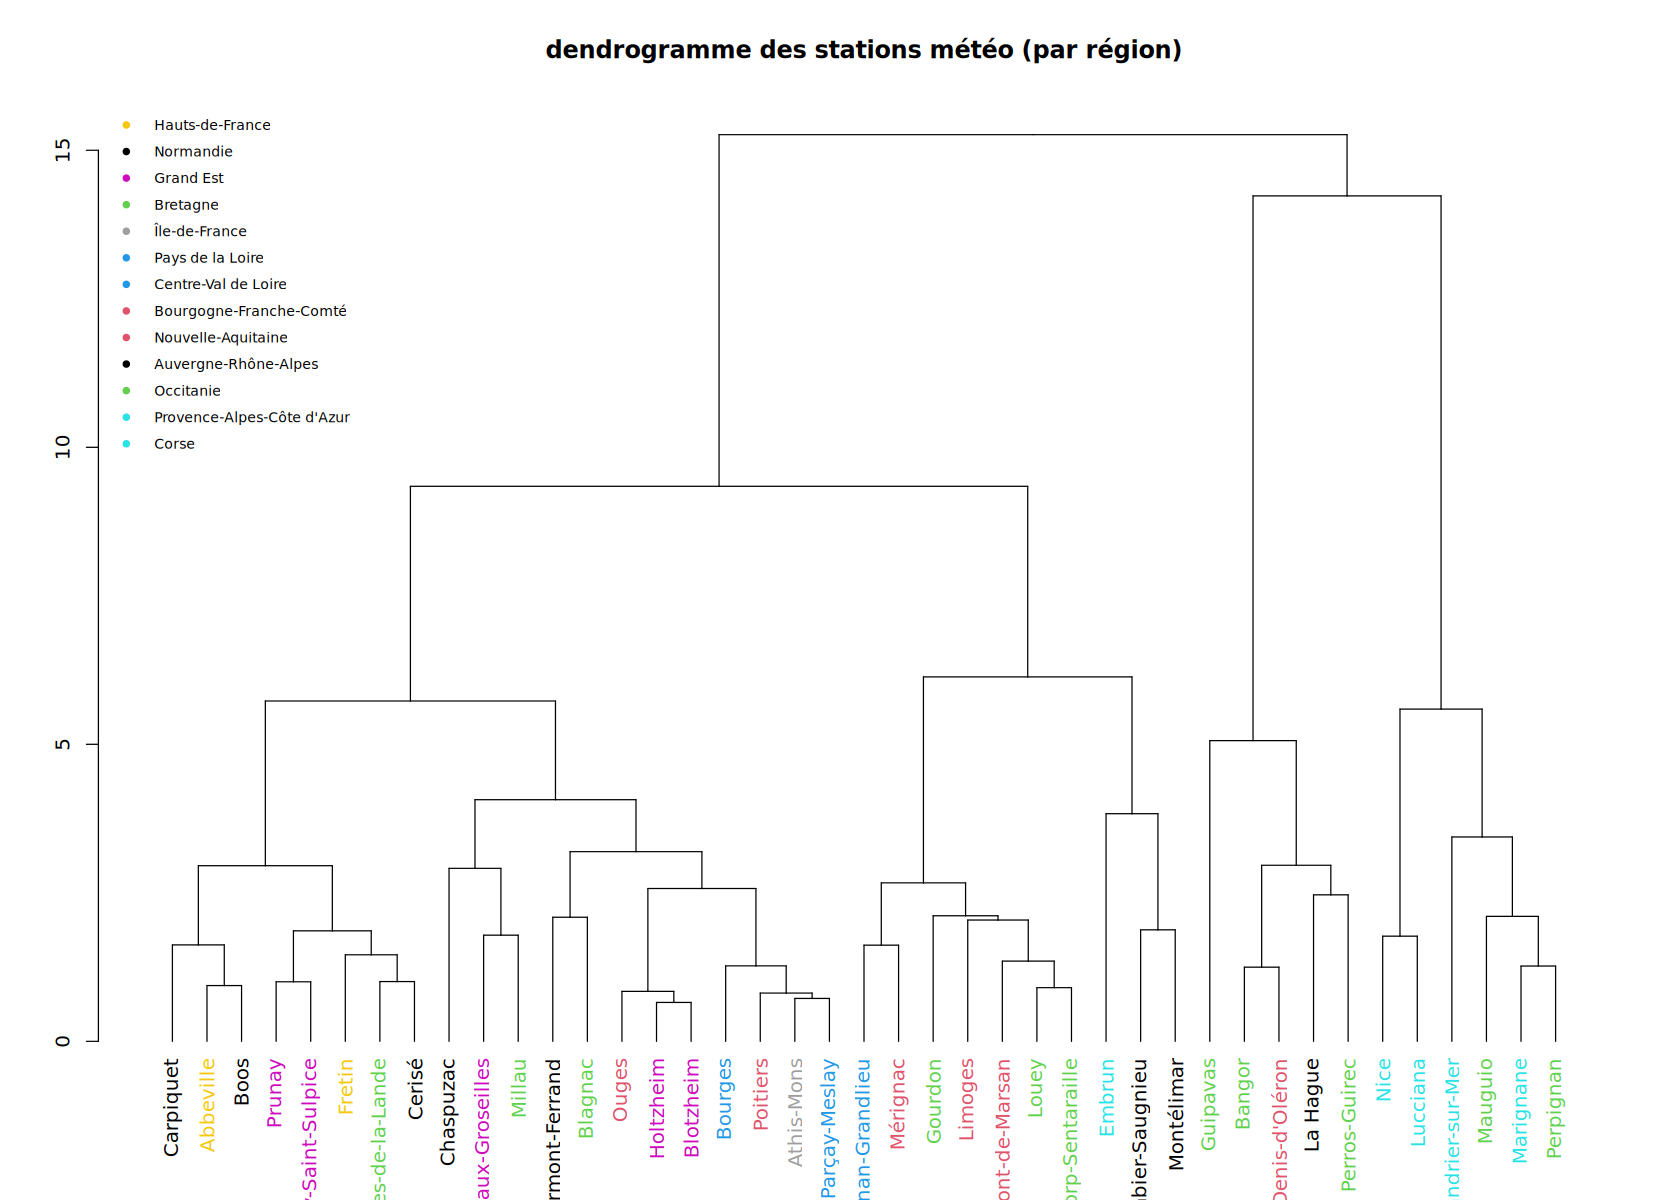

In [ ]:
d <- dist(data_scaled, method = "euclidean")
hc_res <- hclust(d, method = "ward.D2")

dend <- as.dendrogram(hc_res)
regions <- stations_france$region..name.
region_colors <- as.numeric(as.factor(regions))  # transforme chaque région en un code couleur
labels_colors(dend) <- region_colors[order.dendrogram(dend)] 

options(repr.plot.width=14, repr.plot.height=10) 
par(bg = 'white')
plot(dend, main = "dendrogramme des stations météo (par région)",
     cex = 0.6, hang = -1)

legend("topleft", legend = unique(regions),
       col = unique(region_colors), pch = 19, cex = 0.7, bty = "n")

Enfin, on plot les résultats sur la carte de la France métropolitaine

In [16]:
clusters_hc <- cutree(hc_res, k = 6)
stations_france$cluster <- factor(clusters_hc)

Warning message:
“Raster pixels are placed at uneven horizontal intervals and will be shifted
ℹ Consider using `geom_tile()` instead.”


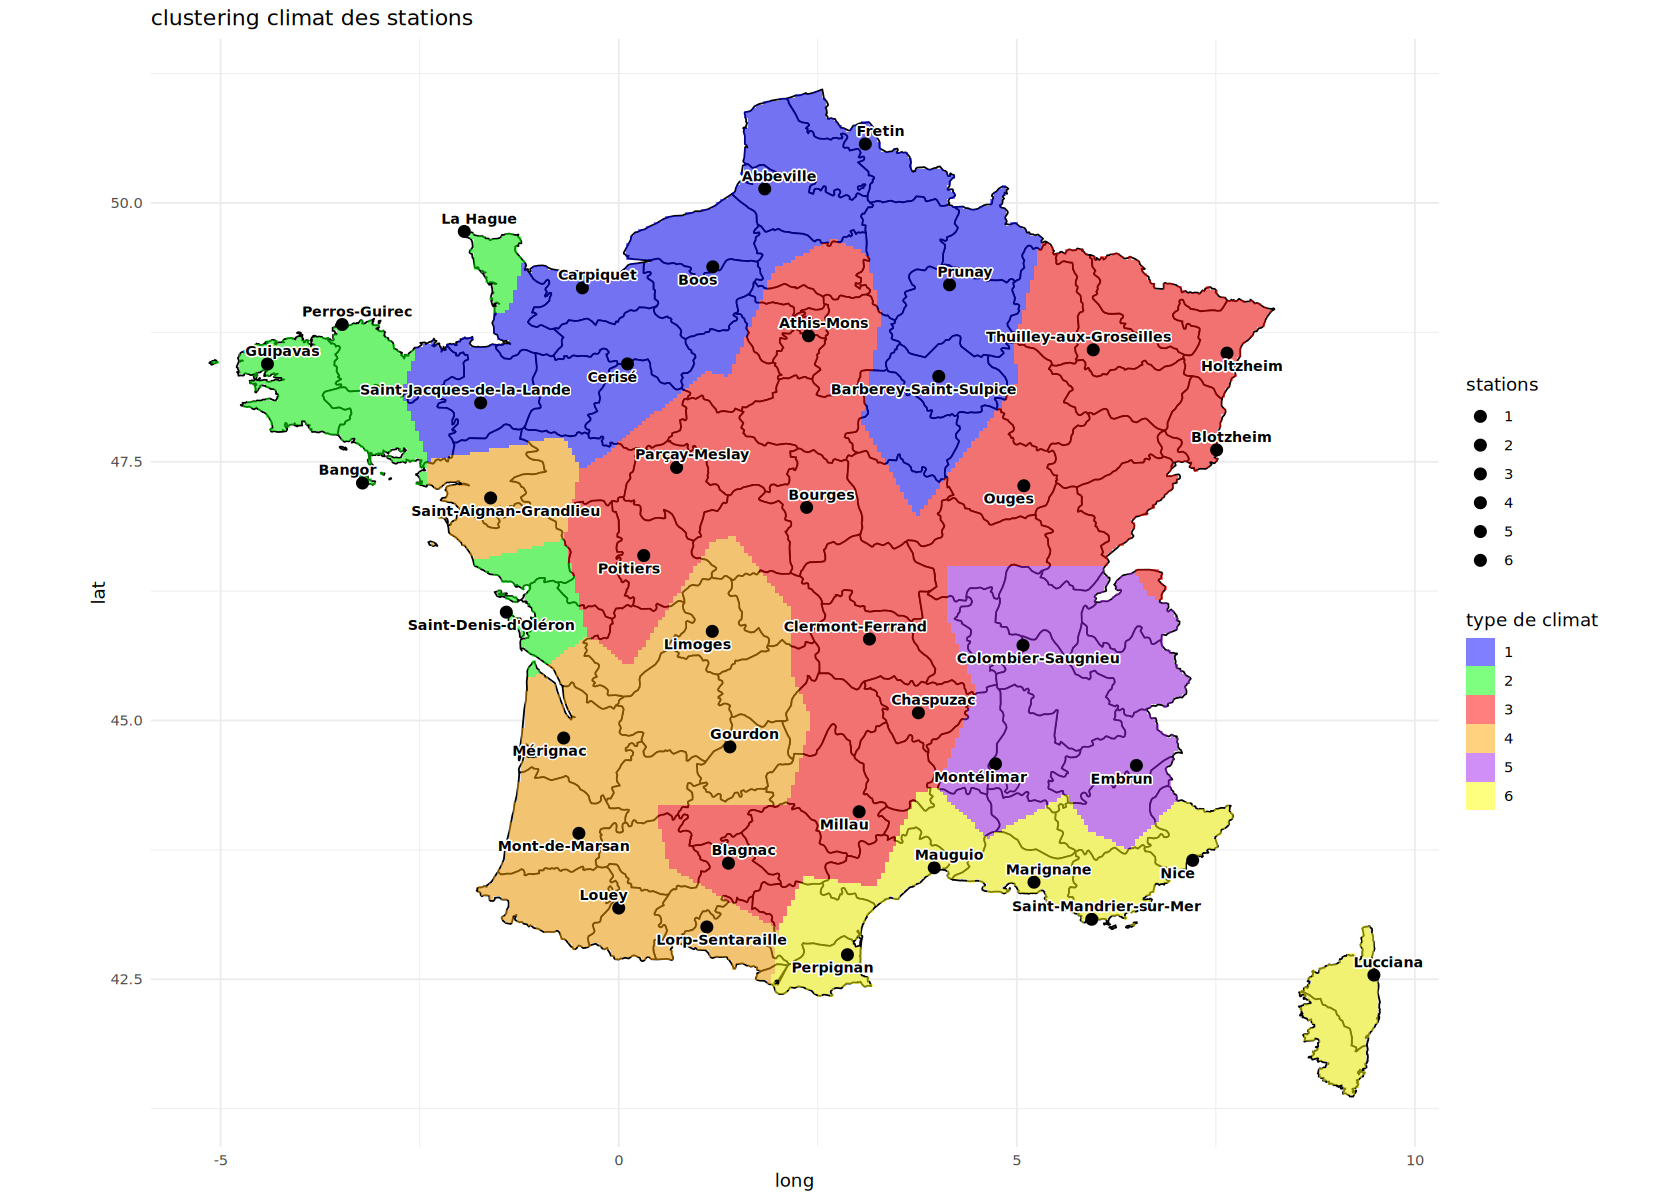

In [17]:
france_map <- map_data("france")

x_seq <- seq(min(france_map$long), max(france_map$long), length.out = 300)
y_seq <- seq(min(france_map$lat), max(france_map$lat), length.out = 300)
grid <- expand.grid(Longitude = x_seq, Latitude = y_seq)

inside_any <- rep(0, nrow(grid))

for(g in unique(france_map$group)){
  poly <- france_map[france_map$group == g, ]
  inside <- point.in.polygon(grid$Longitude, grid$Latitude,
                             poly$long, poly$lat)
  inside_any <- pmax(inside_any, inside)
}

grid <- grid[inside_any > 0, ]

nn <- get.knnx(stations_france[,c("Longitude","Latitude")], 
               grid, k = 1)
grid$cluster <- stations_france$cluster[nn$nn.index]

ggplot() +
  geom_polygon(data = france_map,
               aes(x = long, y = lat, group = group),
               fill = "grey90", color = "black") +
  geom_raster(data = grid,
              aes(x = Longitude, y = Latitude, fill = cluster),
              alpha = 0.5) +
  geom_point(data = stations_france,
             aes(x = Longitude, y = Latitude, color = cluster),
             size = 2) +
  
  geom_point(data = stations_france,
             aes(x = Longitude, y = Latitude, color = cluster),
             size = 3) +
  geom_text_repel(data = stations_france,
                  aes(x = Longitude, y = Latitude, 
                      label = communes..name., color = cluster),
                  size = 3, max.overlaps = 20,
                  fontface = "bold",
                  bg.color = "white", bg.r = 0.15) + # surlignage des textes
  
  coord_fixed(1.3, xlim = range(france_map$long), ylim = range(france_map$lat)) +
  theme_minimal() +
  labs(title = "clustering climat des stations",
       fill = "type de climat", color = "stations") +
  scale_fill_manual(values = c(
    "1" = "blue",
    "2" = "green",
    "3" = "red",
    "4" = "orange",
    "5" = "purple",
    "6" = "yellow"
  )) +
  scale_color_manual(values = c(
    "1" = "black",
    "2" = "black",
    "3" = "black",
    "4" = "black",
    "5" = "black",
    "6" = "black"
  ))
